In [1]:
from mcbj import *
import plots

from tqdm.notebook import tqdm

date = "21_12_08"
sample_rate = 50_000
home_folder = Path(f"D:/BJ_Data/{date}")
import numpy as np

In [2]:
histograms = Histogram(home_folder, start_trace=8001, end_trace=23000)

In [3]:
histograms.calc_time_until_hold_hist()

Calculating histogram of time passed between the rupture of 1G0configuration and hold measurement:   0%|      …

(0, 0.28858)


### Time until hold histogram

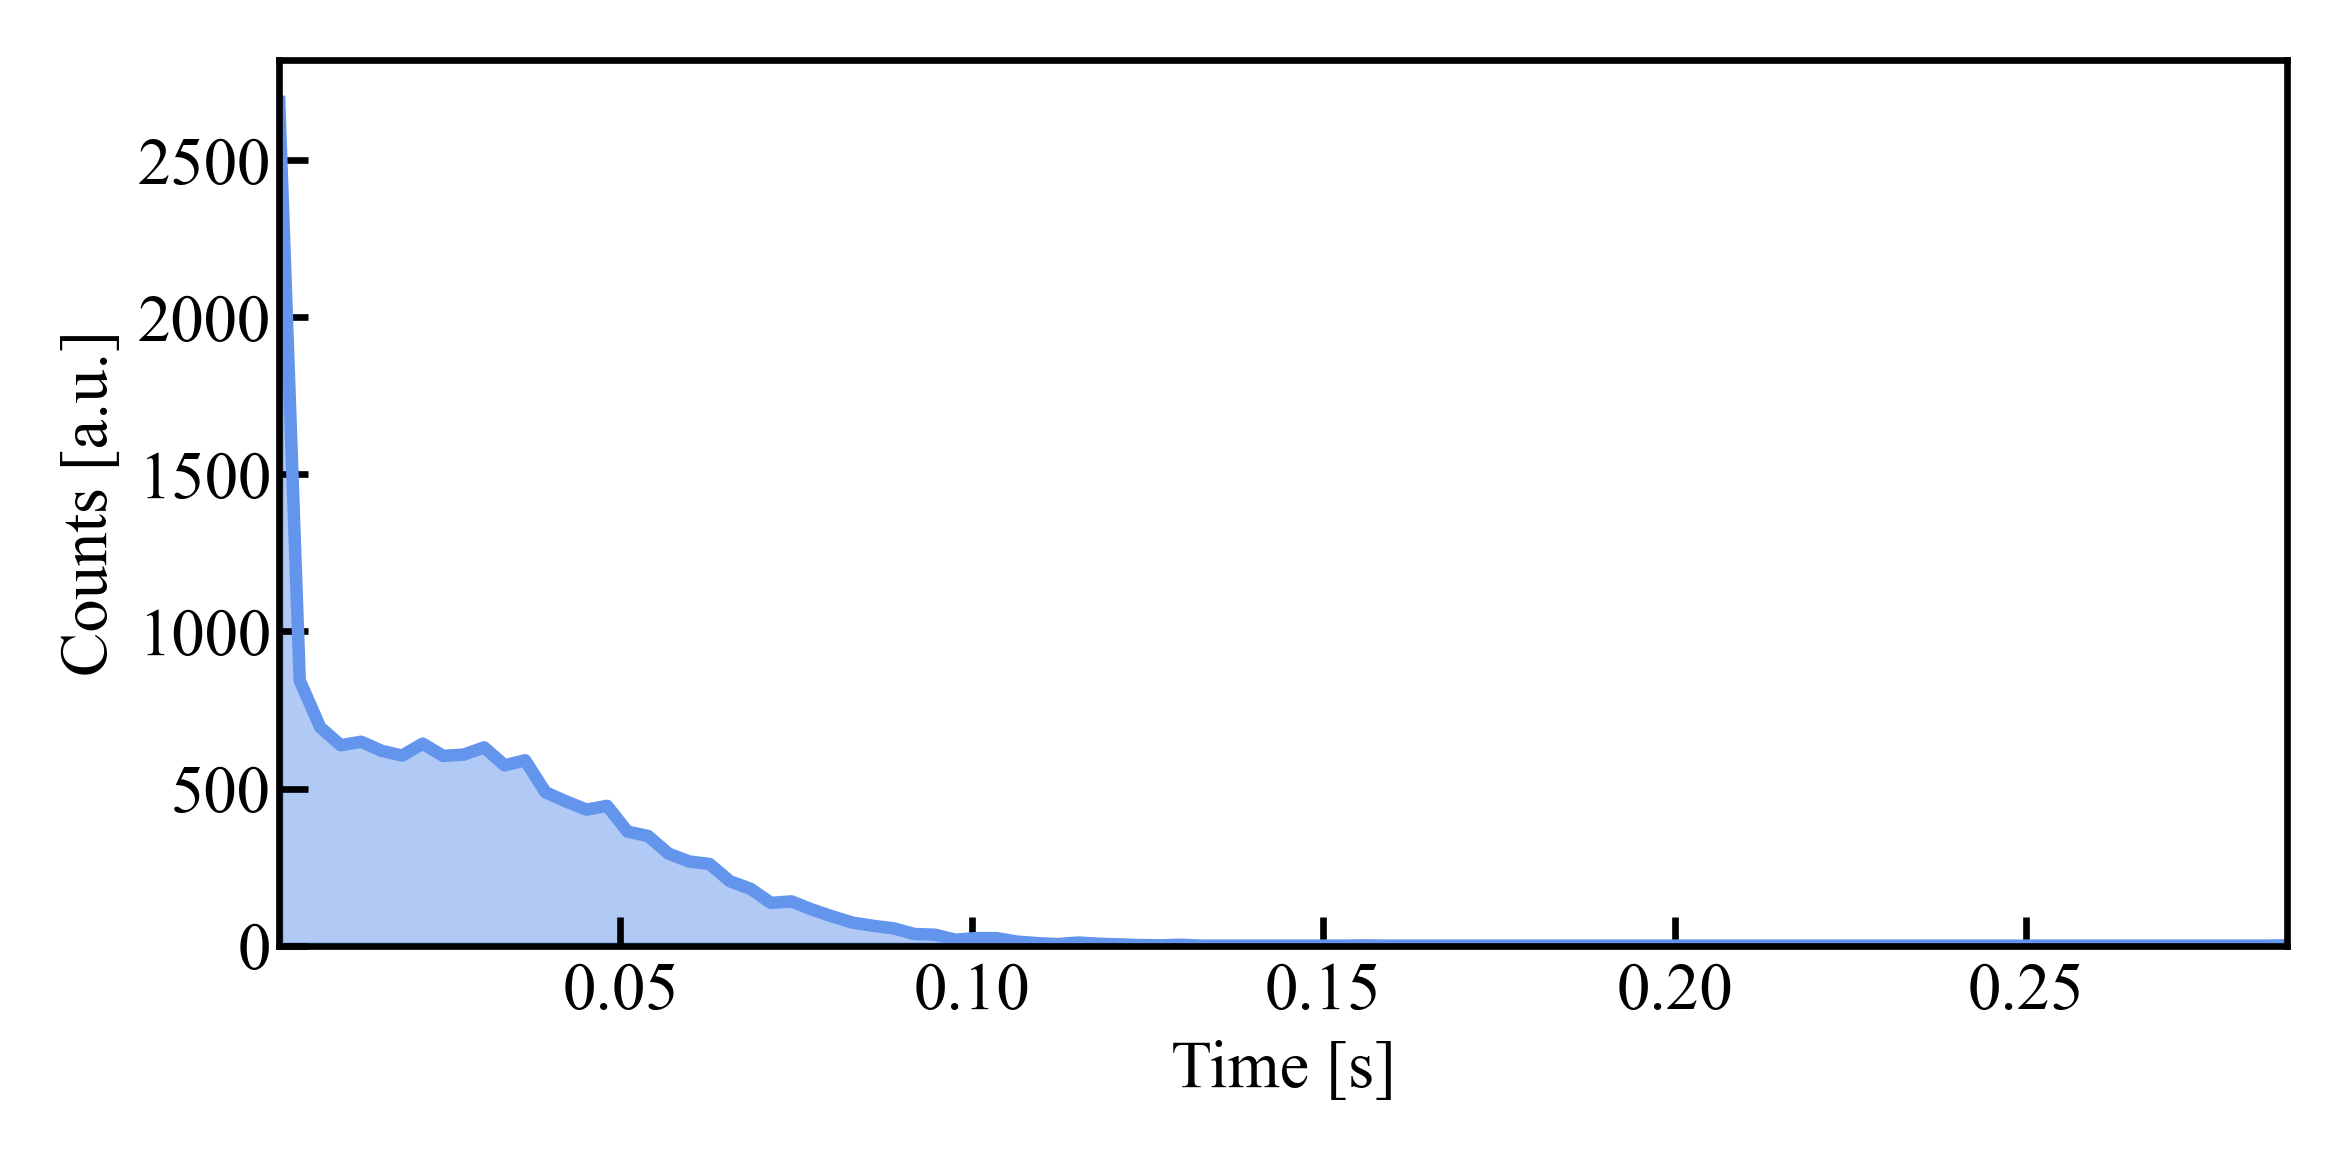

In [4]:
ax = histograms.plot_time_until_hold_hist()

In [5]:
histograms.calc_time_until_hold_hist(xrange=(0, 0.12))

Calculating histogram of time passed between the rupture of 1G0configuration and hold measurement:   0%|      …

(0, 0.12)


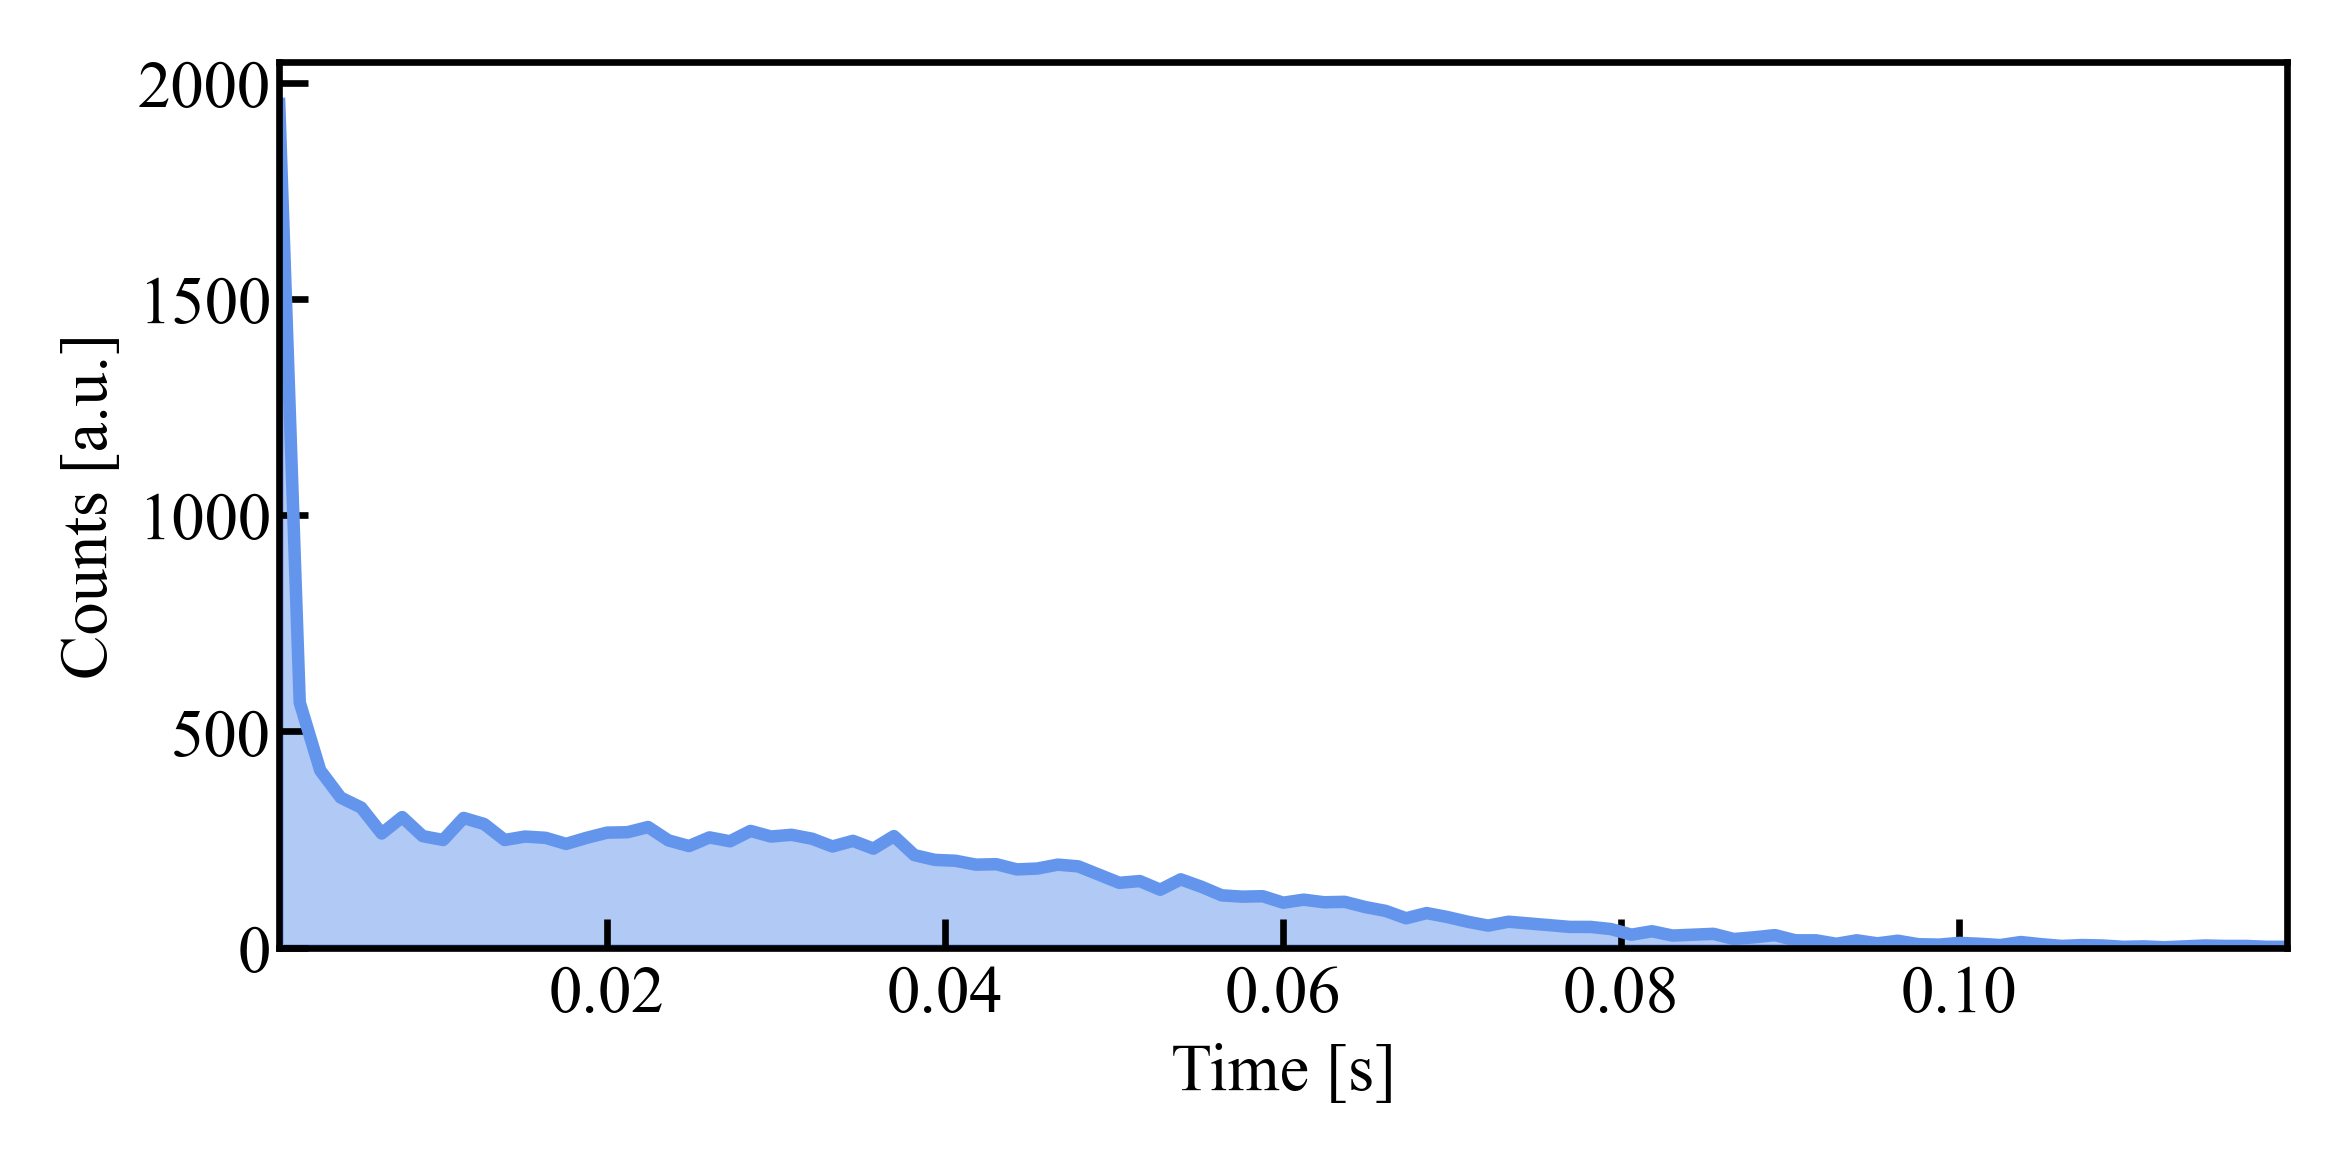

In [6]:
ax = histograms.plot_time_until_hold_hist()

Large peak visible at short times, i.e. that it is common that hold measurement comes right after the rupture of the 1G0 plateau.

In [7]:
def does_not_break(conductance):
#     return np.all(conductance > 1e-5)  # very strict
#     return np.sum(conductance > 1e-5) > 0.998*len(conductance)  # still more strict than previously used ones
    return np.all(utils.moving_average(conductance, 50) > 1e-5)  # still more strict, but I choose this

def measure_relaxation(conductance):
    scaling_val = np.mean(conductance[:int(len(conductance)/2)])
    scaled_conductance = conductance/scaling_val
    
#     relax_ends_at = np.nonzero(scaled_conductance < 2)[0][0]  # first point that is smaller than 2
# np.nonzero(scaled_conductance > 2)[0][-1]
    try:
        relax_ends_at = np.nonzero(scaled_conductance > 2)[0][-1]  # last point that is larger than 2
        # relaxation is not always larger than a scaling factor of 2, or IS IT?
    except IndexError:
        relax_ends_at = 0
    relax_time = relax_ends_at/50_000
    relax_amount = conductance[0]-conductance[relax_ends_at]
    
    return relax_ends_at, relax_time, relax_amount

def is_stabil(conductance):
    
    relax_ends_at, _, _ = measure_relaxation(conductance)
    
    return relax_ends_at < len(conductance)/3

In [8]:
count_pull = 0
did_not_break_pull = []
count_push = 0
did_not_break_push = []

for i in tqdm(np.arange(8000, 23001)):
    try:
        hold_trace = HoldTrace(i, load_from=home_folder, bias_offset=0.00126,
                               r_serial_ohm=100_000, min_step_len=20_000, min_height=1)
    except KeyError:
        continue
        
    if does_not_break(hold_trace.hold_conductance_pull[:hold_trace.bias_steps_ranges_pull[0, 1]]):
        count_pull+=1
        did_not_break_pull.append(i)
    if does_not_break(hold_trace.hold_conductance_push[:hold_trace.bias_steps_ranges_push[0, 1]]):
        count_push+=1
        did_not_break_push.append(i)

  0%|          | 0/15001 [00:00<?, ?it/s]

In [9]:
print(len(did_not_break_pull)/15001)
print(len(did_not_break_push)/15001)

0.3722418505432971
0.9657356176254916


In [10]:
len(np.intersect1d(np.array(did_not_break_pull), np.array(did_not_break_push)))/15001

0.3578428104793014

In [11]:
relax_ends_at_pull_arr = []
relax_time_pull_arr = []
relax_amount_pull_arr= []
pull_times = []
relax_ends_at_push_arr = []
relax_time_push_arr = []
relax_amount_push_arr = []
push_times = []

for i in tqdm(np.intersect1d(np.array(did_not_break_pull), np.array(did_not_break_push))):
    
    hold_trace = HoldTrace(i, load_from=home_folder, bias_offset=0.00126,
                           r_serial_ohm=100_000, min_step_len=20_000, min_height=1)
    trace_pair = TracePair(f'trace_{i}', load_from=home_folder)

    relax_ends_at_pull, relax_time_pull, relax_amount_pull = measure_relaxation(hold_trace.hold_conductance_pull[:hold_trace.bias_steps_ranges_pull[0, 1]])

    relax_ends_at_push, relax_time_push, relax_amount_push = measure_relaxation(hold_trace.hold_conductance_push[:hold_trace.bias_steps_ranges_push[0, 1]])
    try:
        pull_times.append((trace_pair.hold_index_pull - trace_pair.plateau_range_pull[1])
                          / trace_pair.sample_rate)
        push_times.append((trace_pair.plateau_range_push[0] - trace_pair.hold_index_push)
                          / trace_pair.sample_rate)
    except TypeError:
        if len(pull_times) > len(push_times):
            pull_times.pop()
        print(f'Something wrong with trace {i}.')
        continue

    relax_ends_at_push_arr.append(relax_ends_at_push)
    relax_time_push_arr.append(relax_time_push)
    relax_amount_push_arr.append(relax_amount_push)

    relax_ends_at_pull_arr.append(relax_ends_at_pull)
    relax_time_pull_arr.append(relax_time_pull)
    relax_amount_pull_arr.append(relax_amount_pull)
    
relax_ends_at_pull = np.array(relax_ends_at_pull_arr)
relax_time_pull = np.array(relax_time_pull_arr)
relax_amount_pull = np.array(relax_amount_pull_arr)
relax_ends_at_push = np.array(relax_ends_at_push_arr)
relax_time_push = np.array(relax_time_push_arr)
relax_amount_push = np.array(relax_amount_push_arr)
pull_times = np.array(pull_times)
push_times = np.array(push_times)

  0%|          | 0/5368 [00:00<?, ?it/s]

Something wrong with trace 16769.
Something wrong with trace 19292.
Something wrong with trace 20106.


In [13]:
print(len(relax_ends_at_pull))
# print(len(traces))

5365


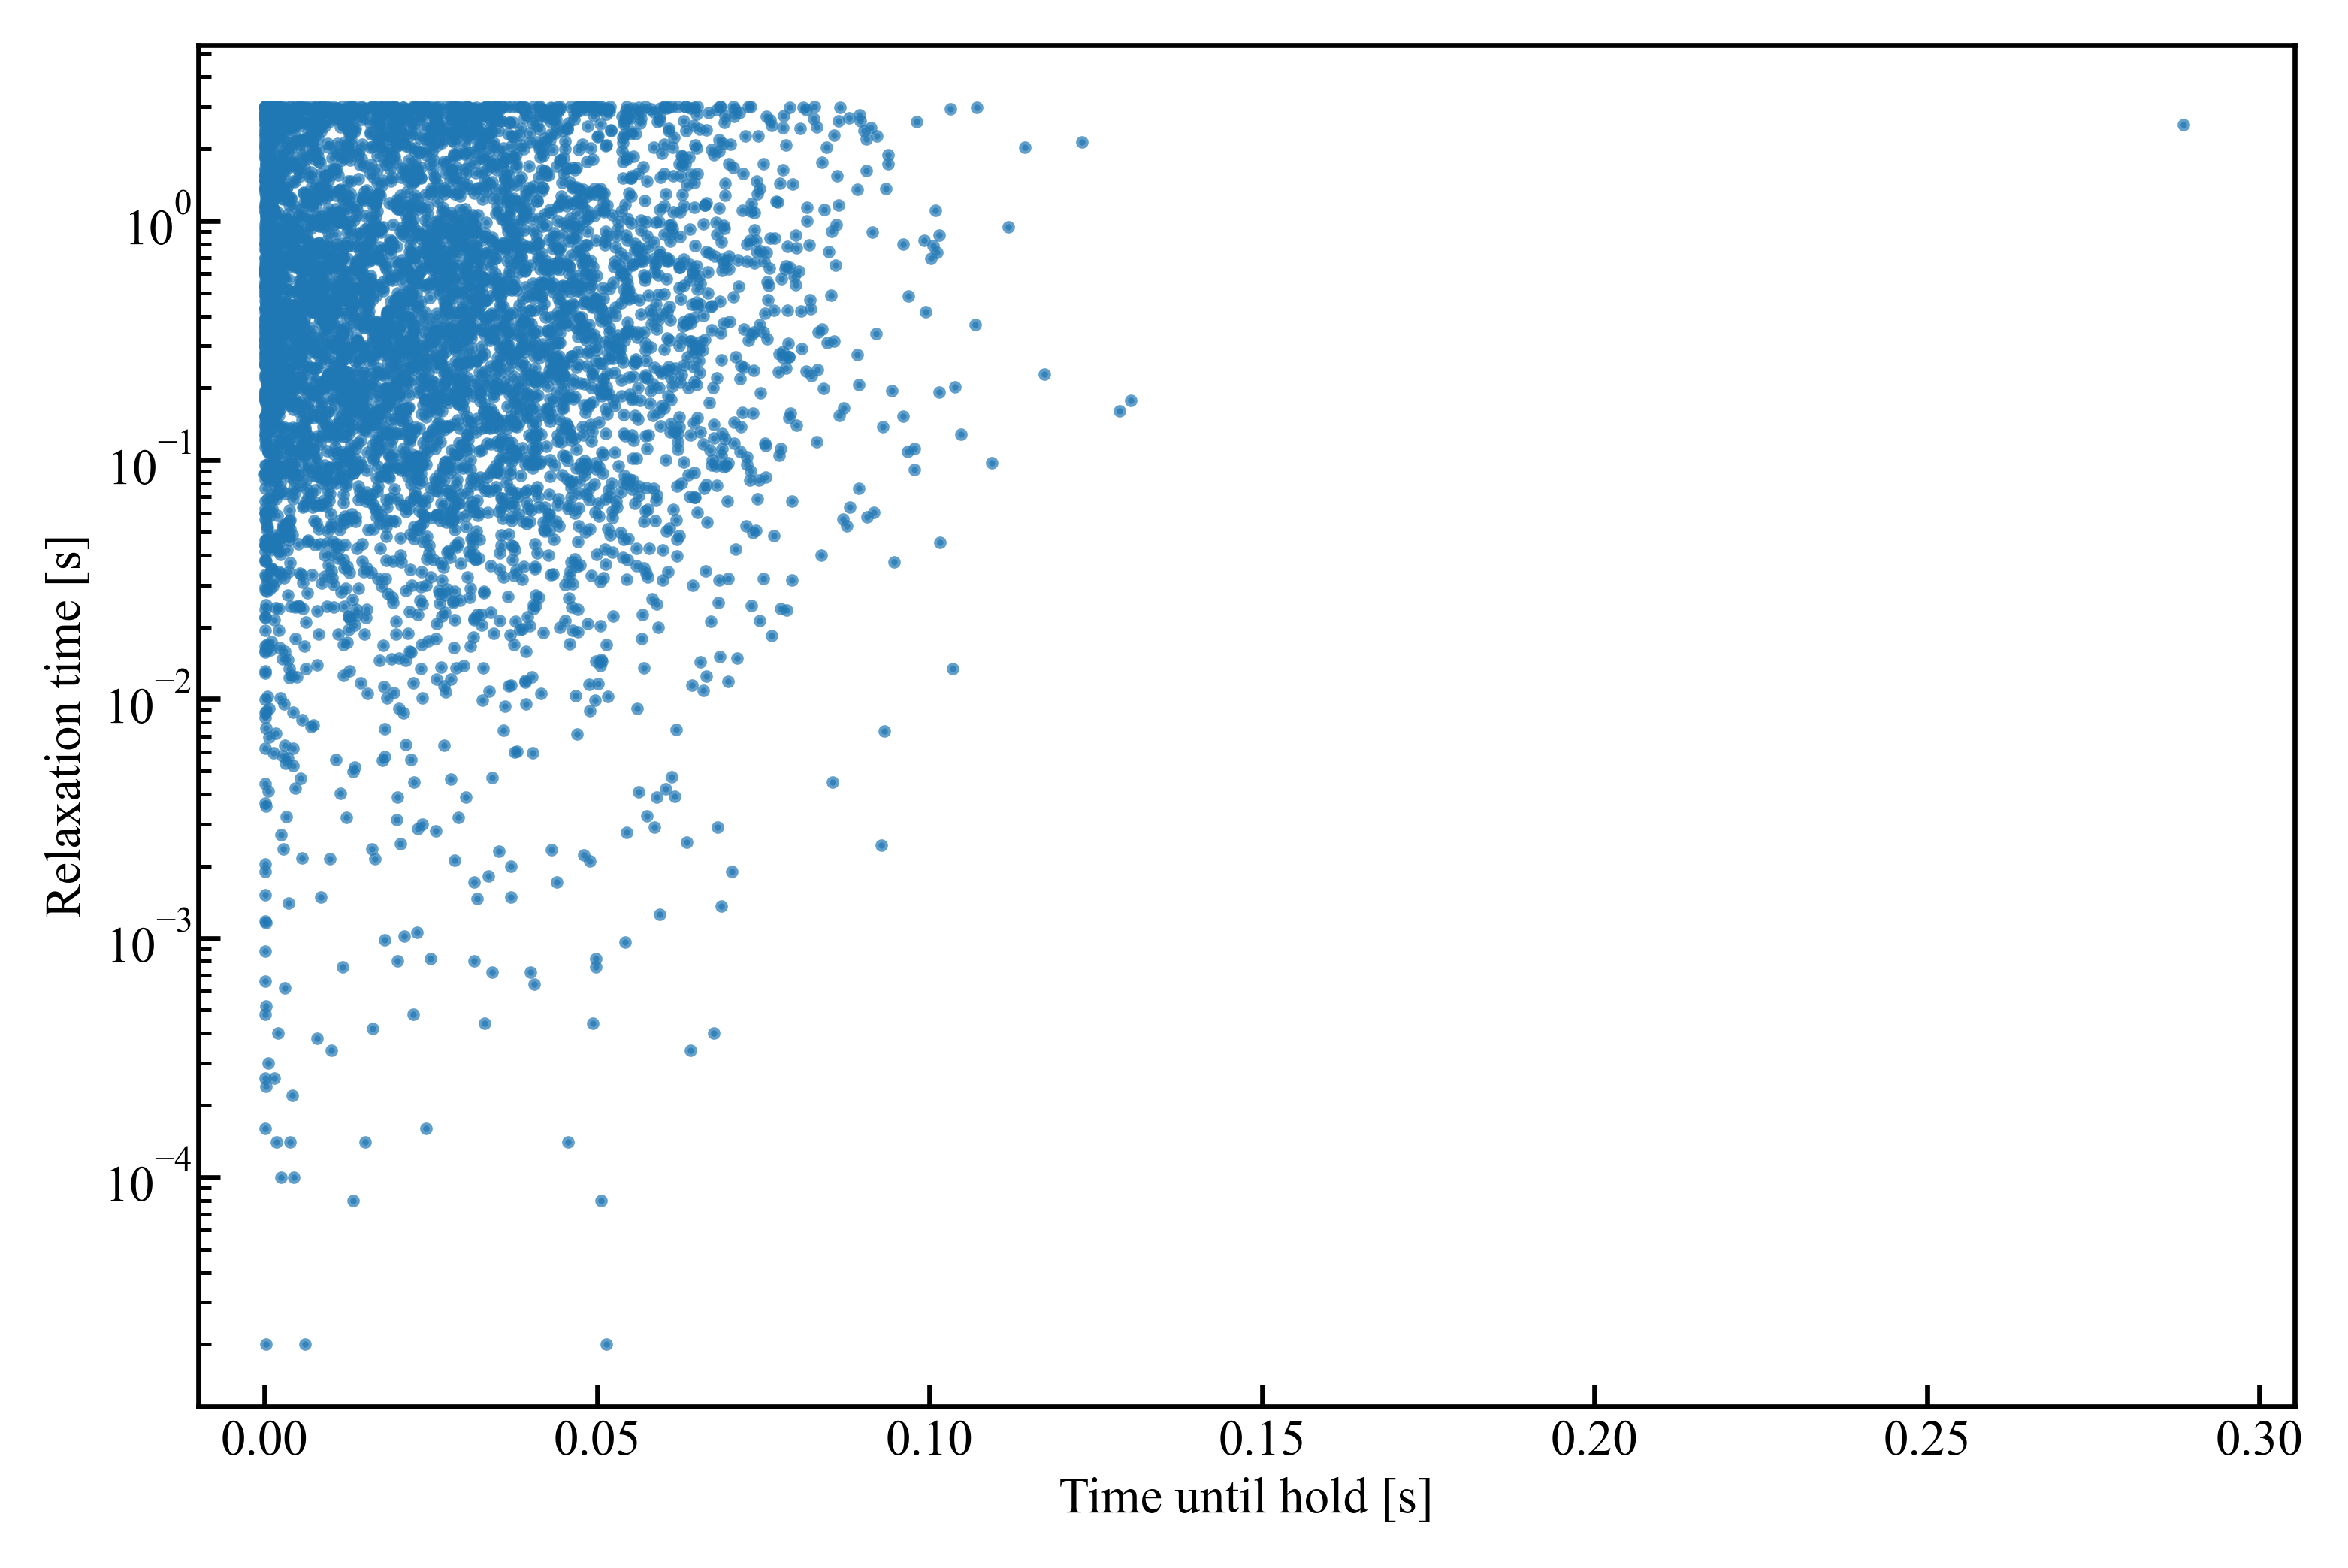

In [14]:
fig, ax = plt.subplots(1, dpi=600)
ax.scatter(pull_times, relax_time_pull, s=1, alpha=0.7)
ax.set_xlabel('Time until hold [s]')
ax.set_ylabel('Relaxation time [s]')
# ax.set_xlim(-0.01, 0.3)
ax.set_xlim(left=-0.01)
ax.set_yscale('log')

In [15]:
print(len(relax_time_pull[relax_time_pull == 0]))

136


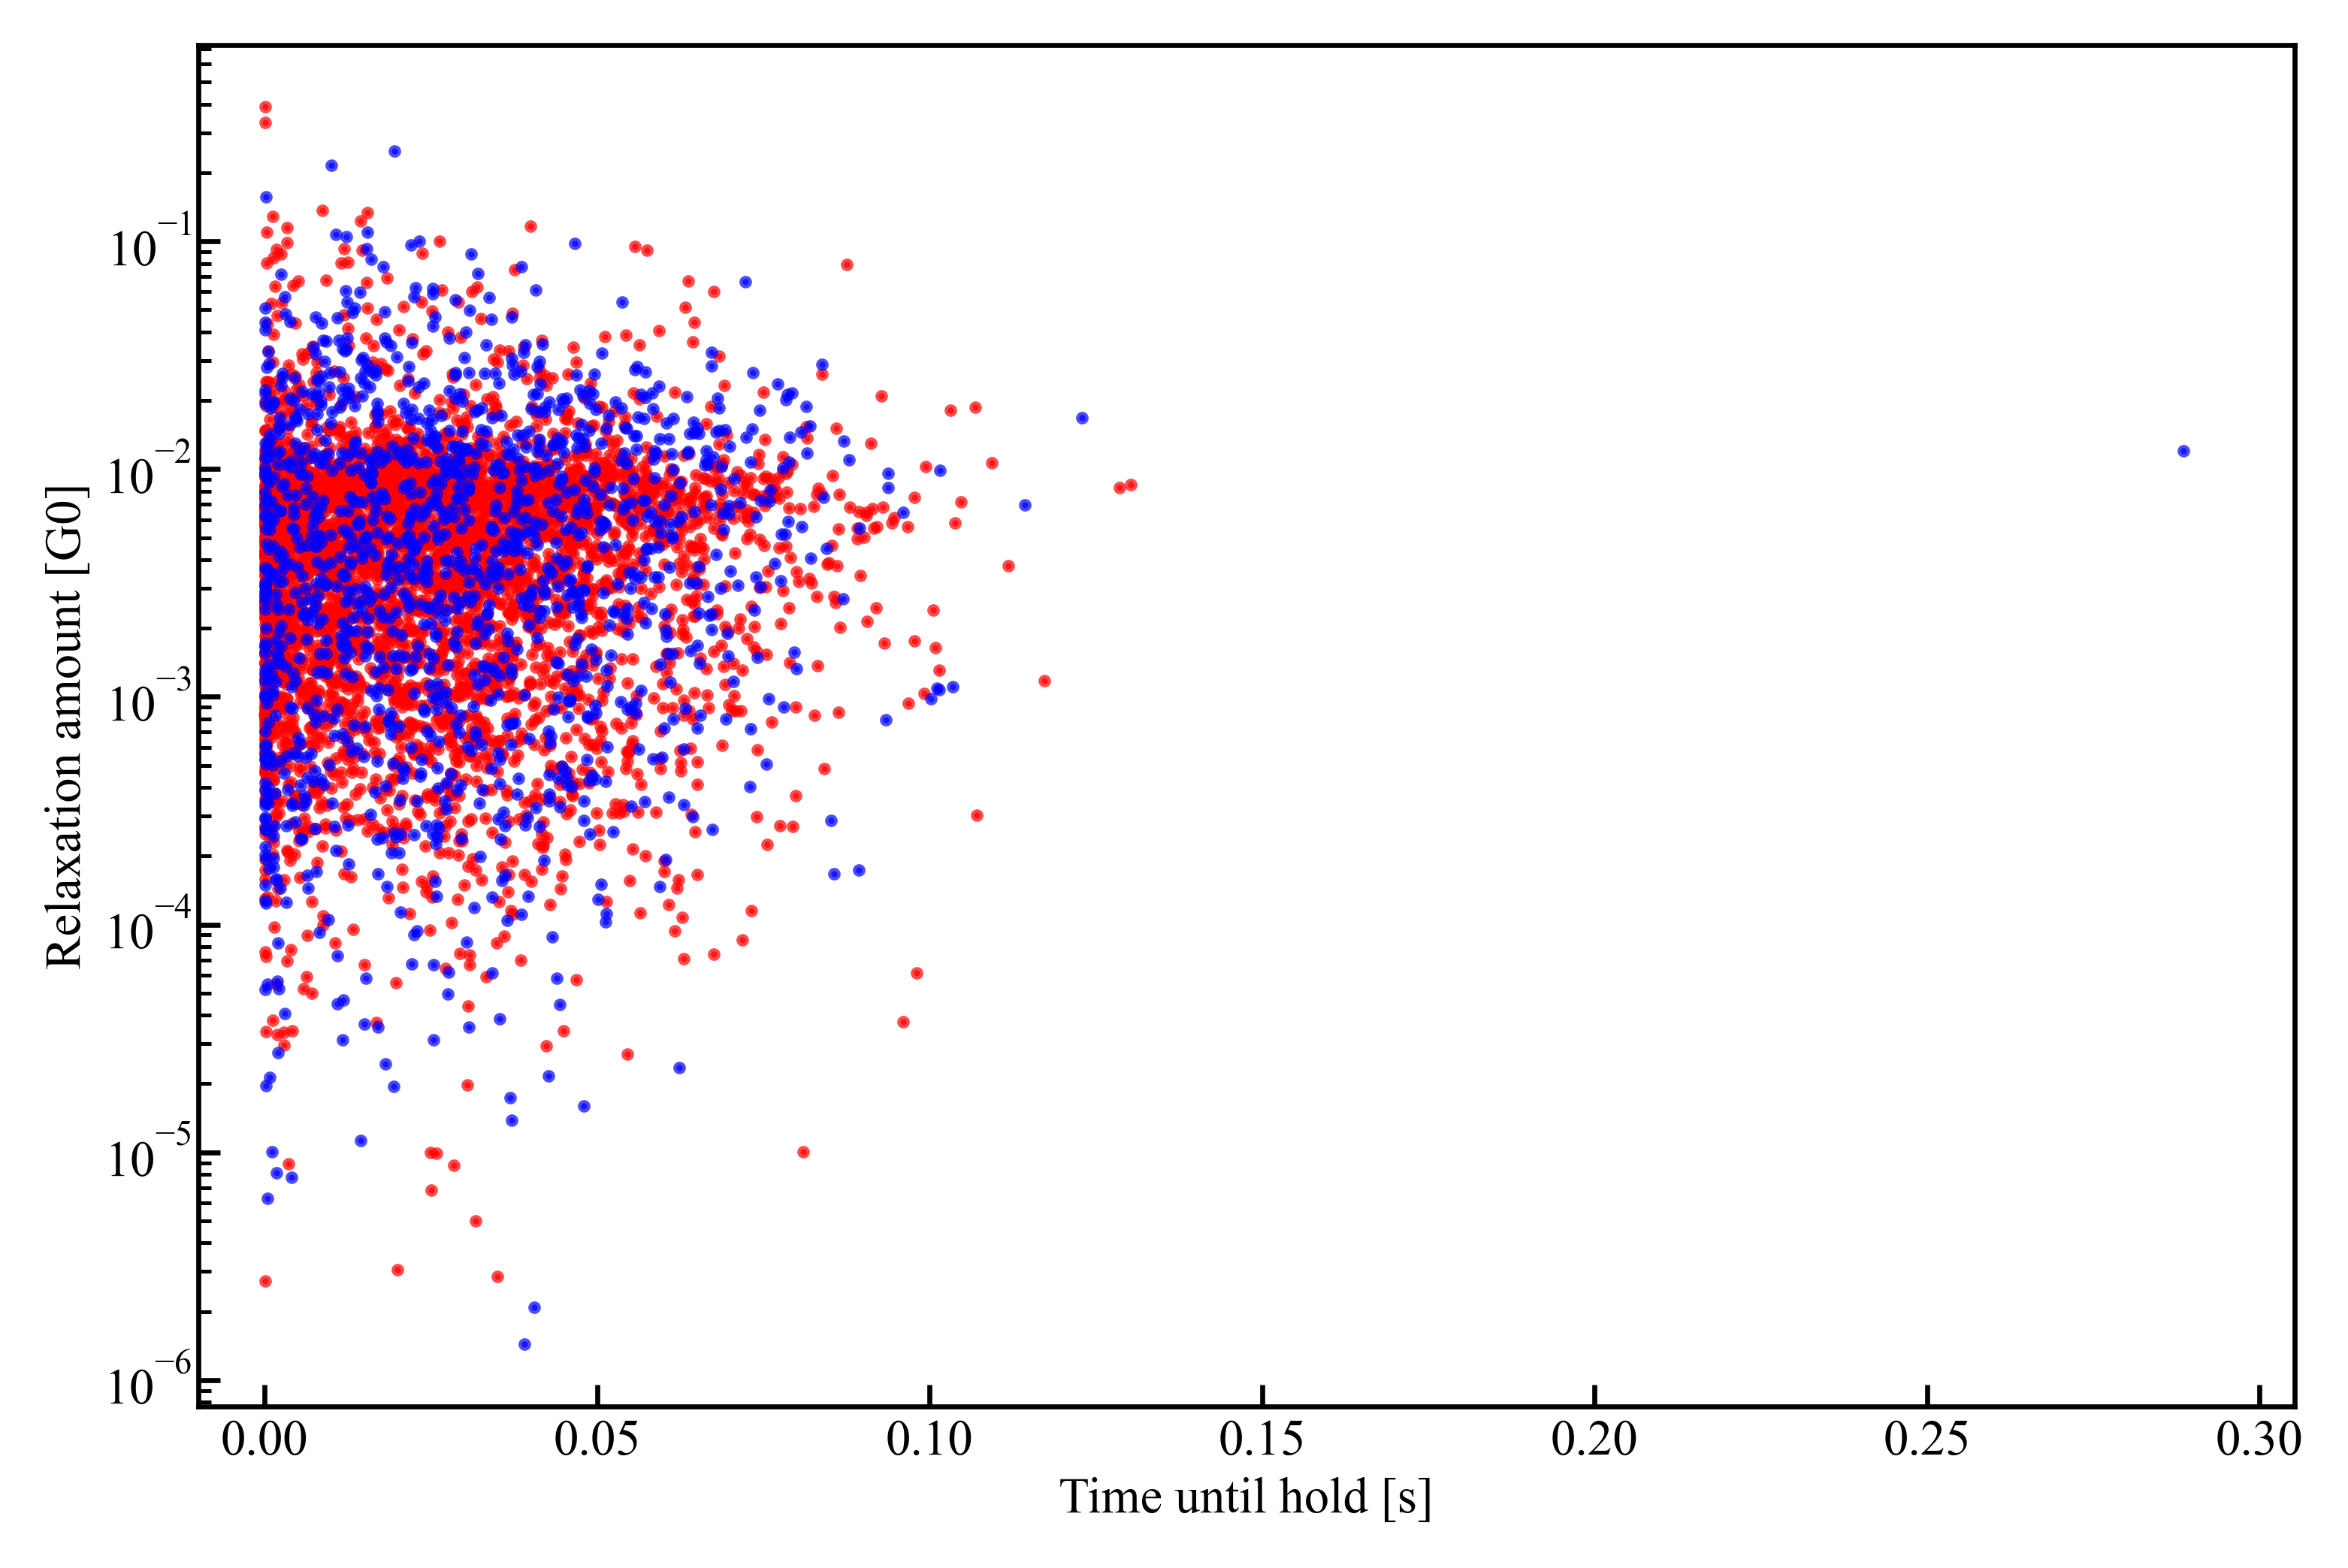

In [16]:
fig, ax = plt.subplots(1, dpi=600)
ax.scatter(pull_times[relax_amount_pull > 0], relax_amount_pull[relax_amount_pull > 0], s=1, alpha=0.7, c='red')
ax.scatter(pull_times[relax_amount_pull < 0], abs(relax_amount_pull[relax_amount_pull < 0]), s=1, alpha=0.7, c='blue')
ax.set_xlabel('Time until hold [s]')
ax.set_ylabel('Relaxation amount [G0]')
# ax.set_xlim(-0.01, 0.3)
ax.set_xlim(left=-0.01)
ax.set_yscale('log')

In [17]:
print(len(relax_amount_pull))
print(len(relax_amount_pull[relax_amount_pull < 0]) + len(relax_amount_pull[relax_amount_pull > 0]))
print()

5365
5229



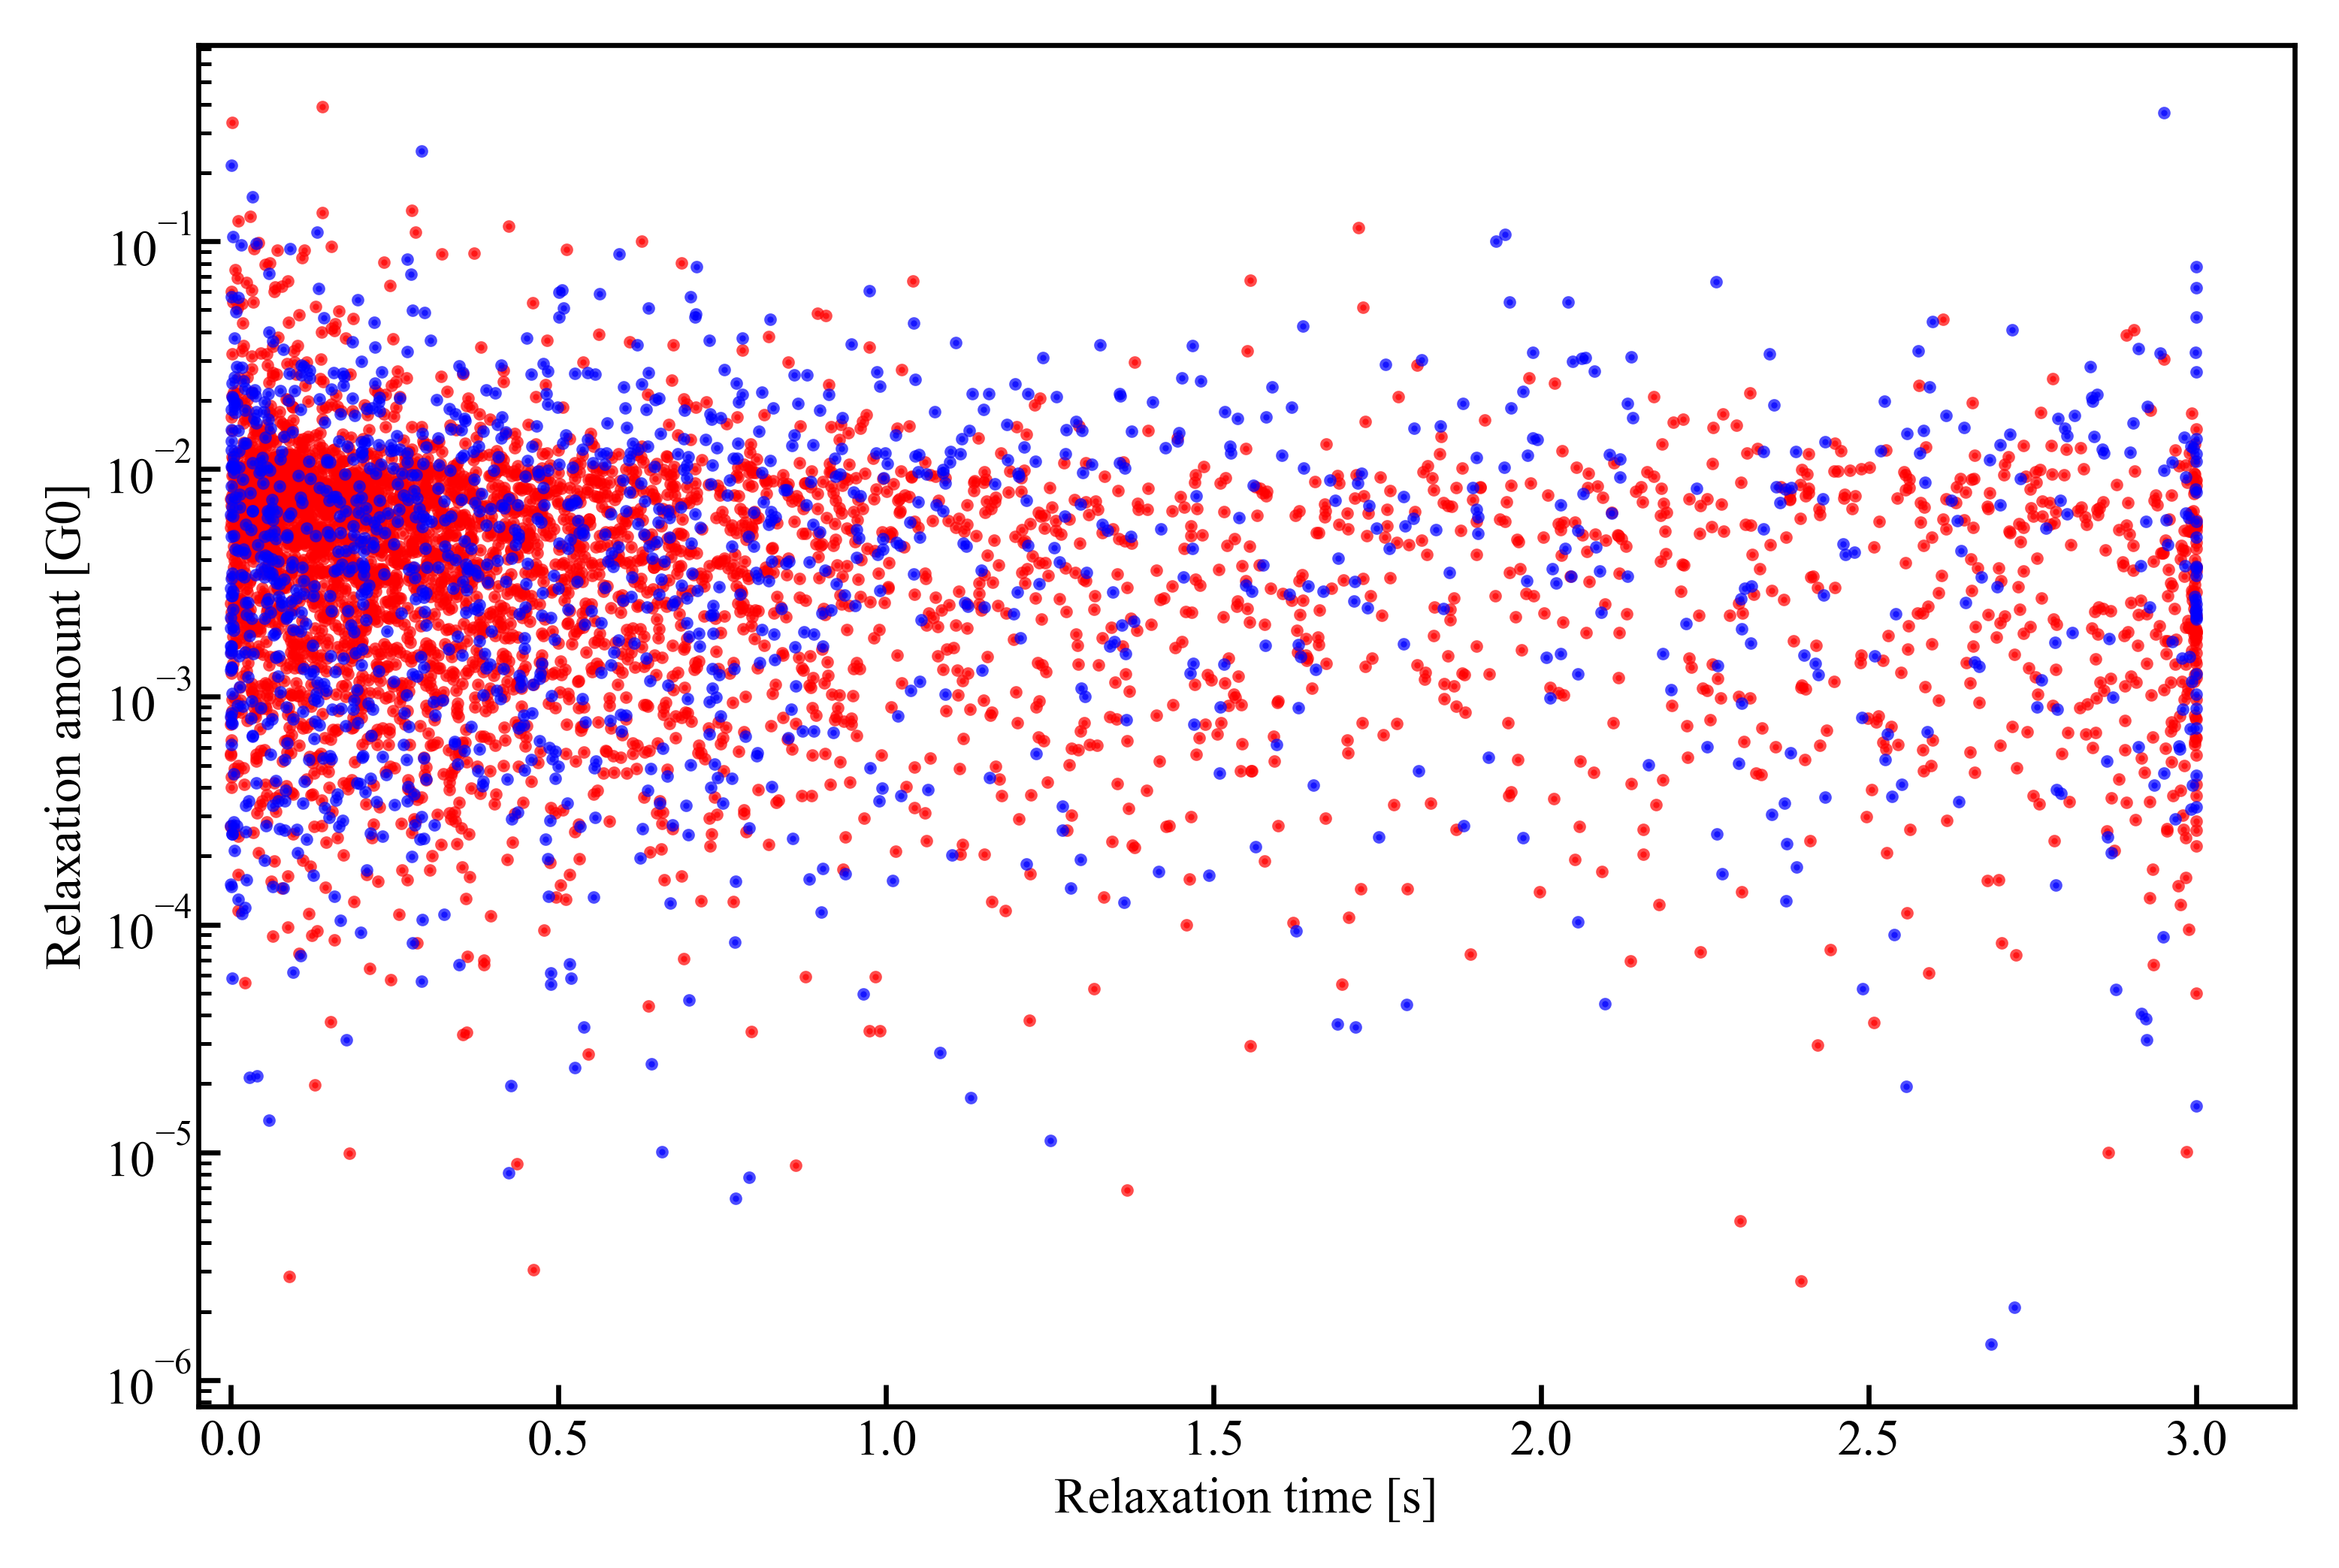

In [18]:
fig, ax = plt.subplots(1, dpi=600)
ax.scatter(relax_time_pull[relax_amount_pull > 0], relax_amount_pull[relax_amount_pull > 0], s=1, alpha=0.7, c='red')
ax.scatter(relax_time_pull[relax_amount_pull < 0], abs(relax_amount_pull[relax_amount_pull < 0]), s=1, alpha=0.7, c='blue')
ax.set_xlabel('Relaxation time [s]')
ax.set_ylabel('Relaxation amount [G0]')
# ax.set_xlim(-0.01, 0.5)
ax.set_xlim(left=-0.05)
ax.set_yscale('log')

In [25]:
traces = np.intersect1d(np.array(did_not_break_pull), np.array(did_not_break_push))
traces = traces[np.bitwise_and(np.bitwise_and(traces!=16769, traces!=19292), traces!=20106)]

In [26]:
traces.shape

(5365,)

In [27]:
relax_time_pull.shape

(5365,)

In [28]:
relax_time_pull = np.array(relax_time_pull)
traces[relax_time_pull < 0.5]

array([ 8008,  8012,  8014, ..., 22931, 22941, 22975])

In [29]:
which_trace = np.random.choice(traces[relax_time_pull < 0.5])
print(which_trace)

hold_trace = HoldTrace(which_trace, load_from=home_folder, bias_offset=0.00126,
                       r_serial_ohm=100_000, min_step_len=20_000, min_height=1)
trace_pair = TracePair(f'trace_{which_trace}', load_from=home_folder)
hold_trace.analyse_hold_trace(num_of_fft=1)

10377


(<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='G $[G_{0}]$'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='G $[G_{0}]$'>)

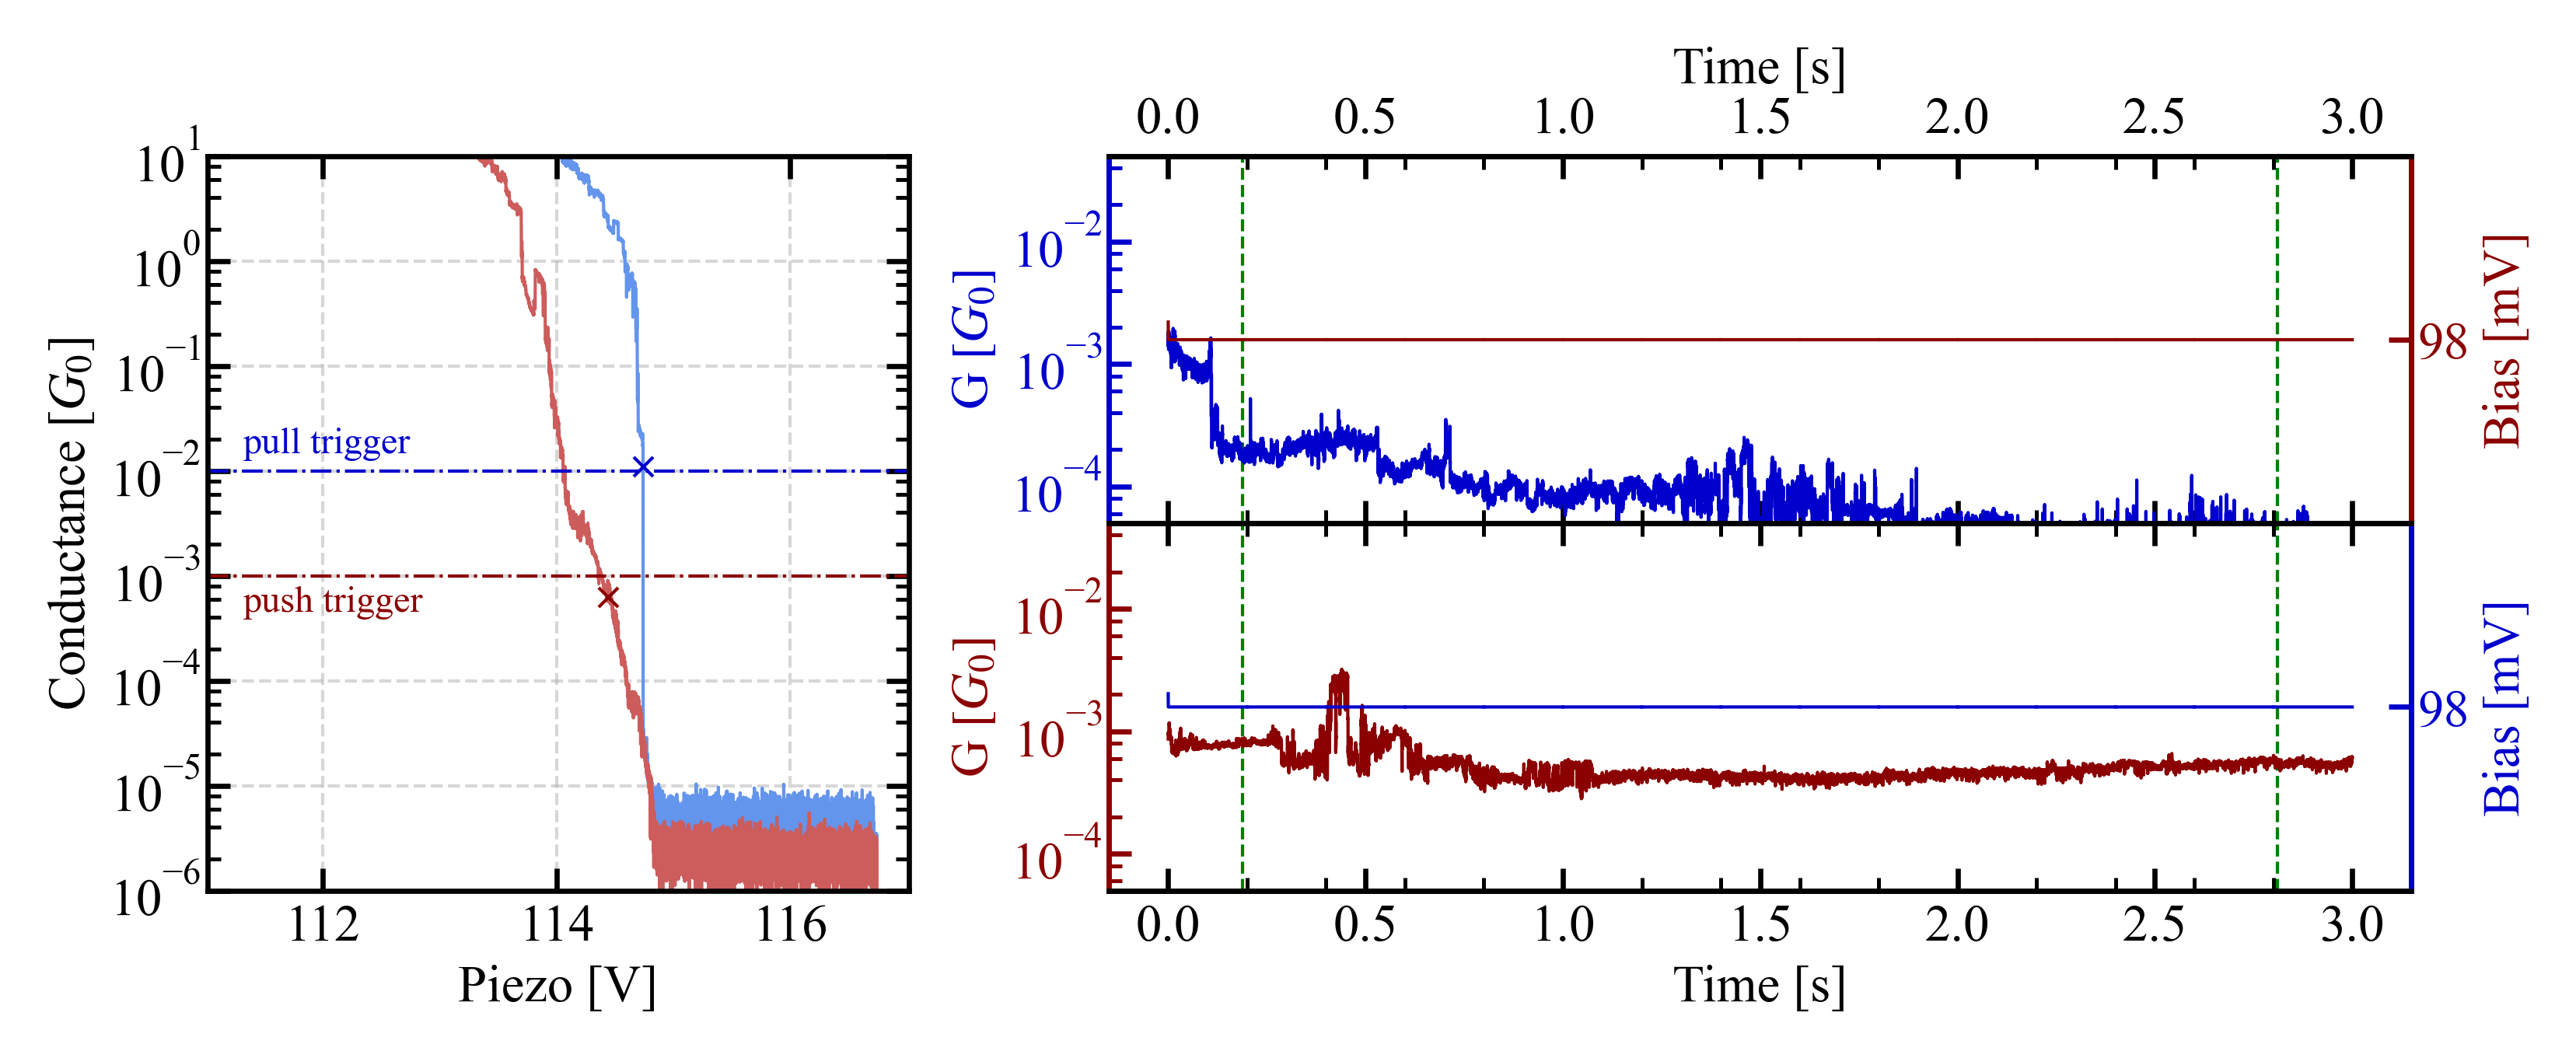

In [30]:
plots.plot_measurement_scheme(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder,
                              main_colors=('cornflowerblue', 'indianred'),
                              accent_colors=('mediumblue', 'darkred'),
                              save_fig=False,
                              xlim=None, smoothing=10)

In [31]:
relax_ends_at, relax_time, relax_amount = measure_relaxation(hold_trace.hold_conductance_pull[:hold_trace.bias_steps_ranges_pull[0, 1]])

In [32]:
# print((trace_pair.hold_index_pull + relax_ends_at)/50_000)
print(relax_ends_at/50_000)
print(relax_time)

0.43138
0.43138


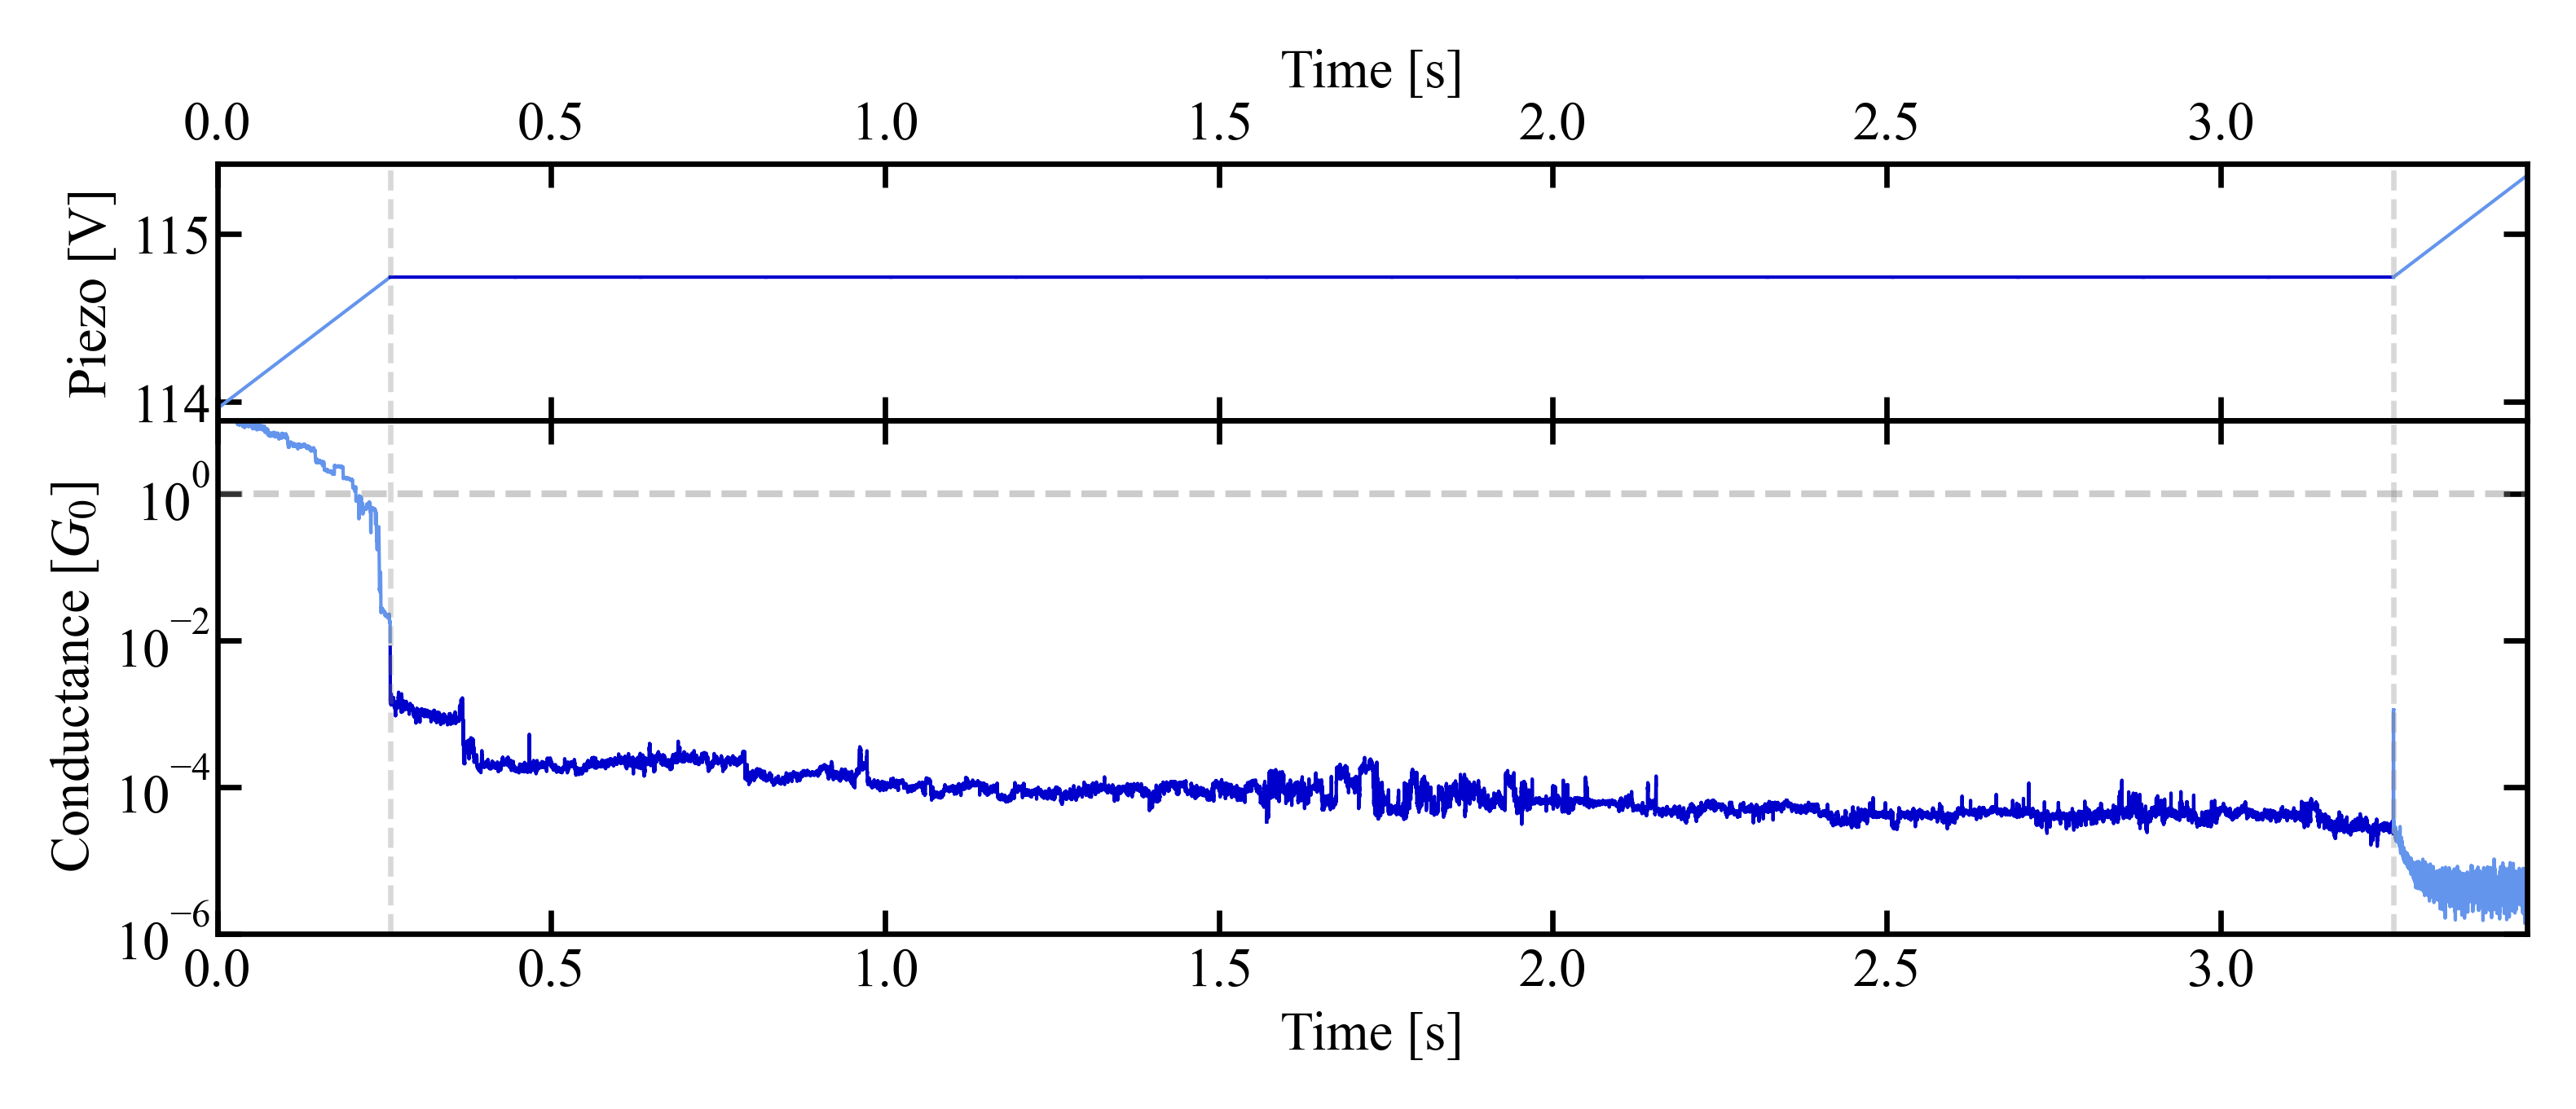

In [34]:
ax_piezo, ax_combed = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='pull',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax_combed.axhline(1, ls='--', c='grey', alpha=0.4, lw = 1)
# ax.axvline((trace_pair.hold_index_pull + relax_ends_at)/50_000, ls='--', c='grey', alpha=0.4, lw = 1)

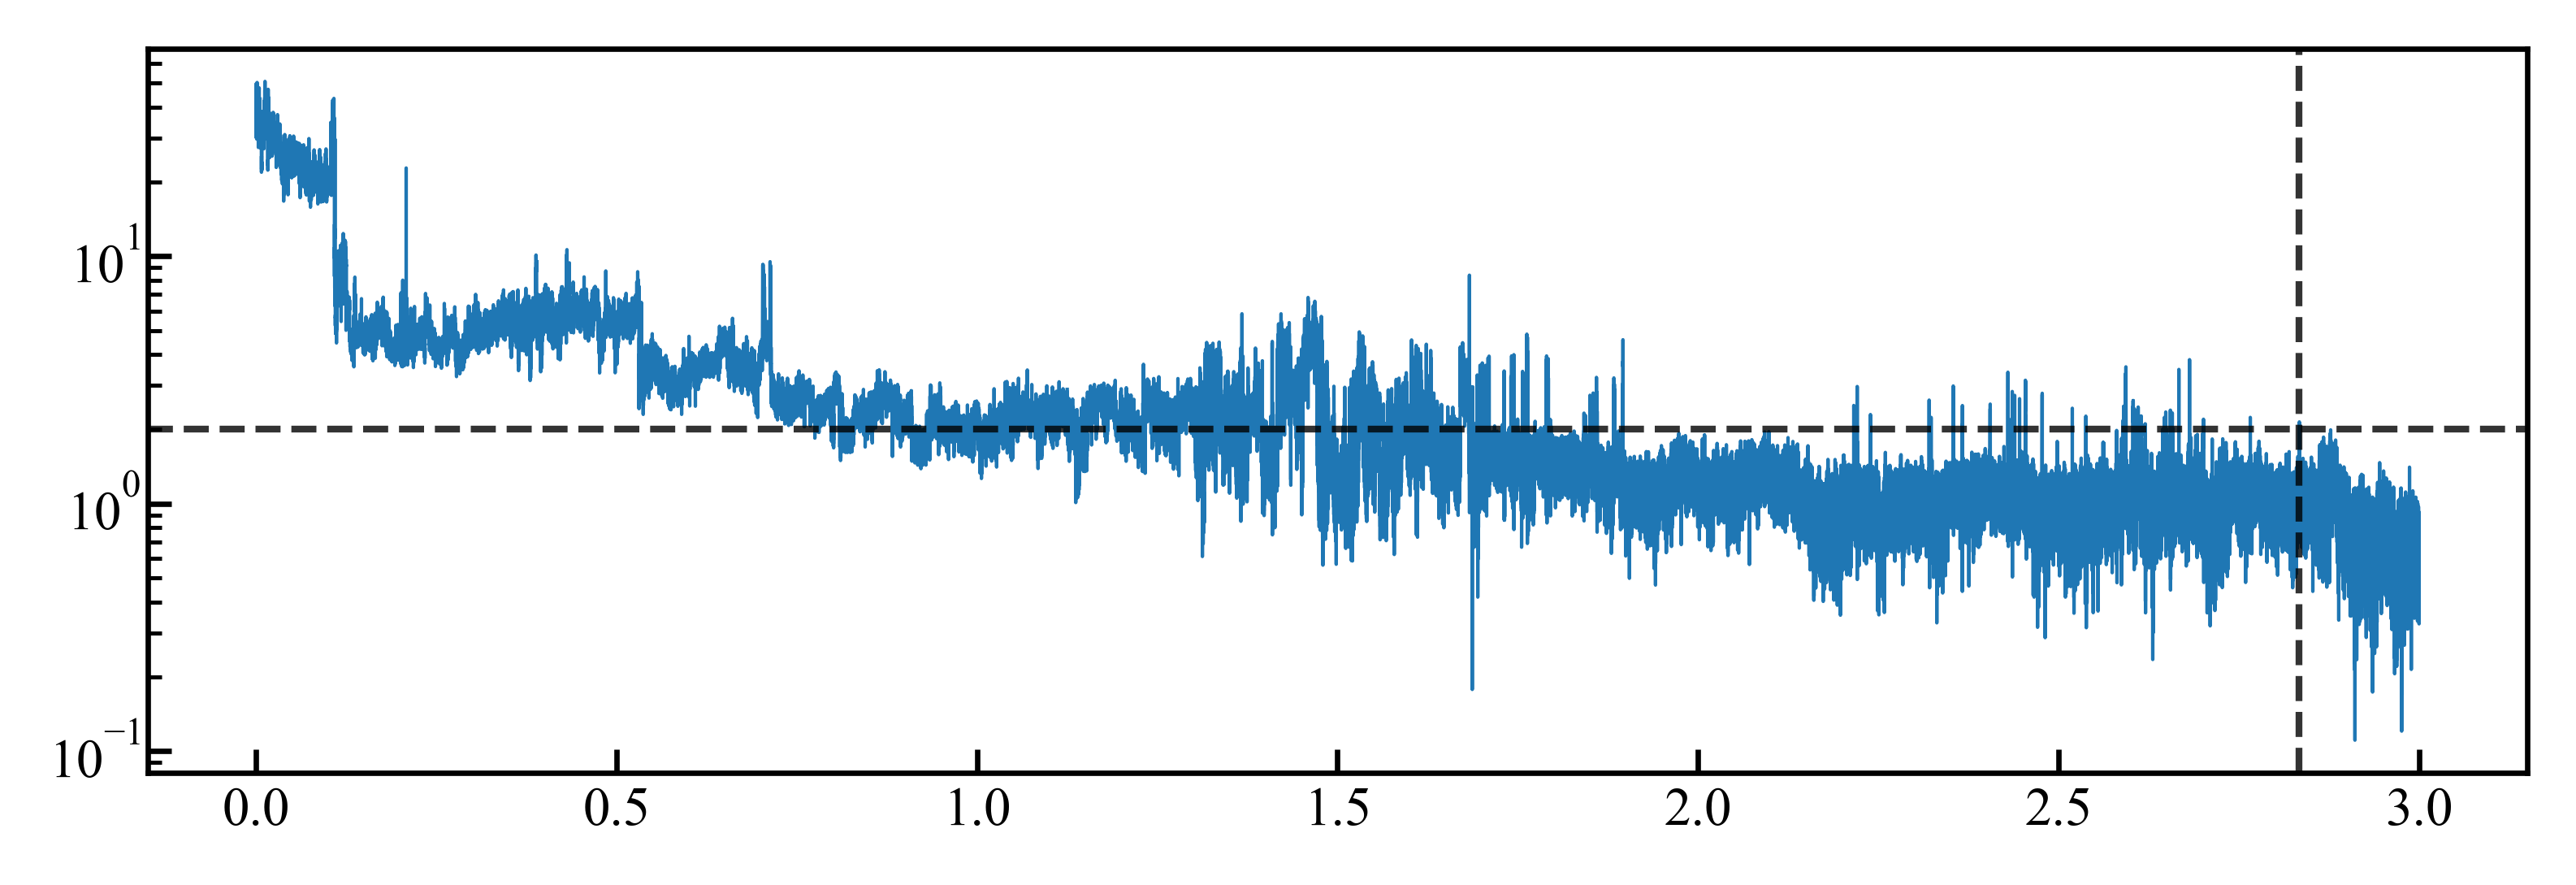

In [35]:
scaled_conductance = hold_trace.hold_conductance_pull/np.mean(hold_trace.hold_conductance_pull[-1*int(len(hold_trace.hold_conductance_pull)/4):])

fig, ax = plt.subplots(1, figsize=utils.cm2inch(16, 5), dpi=600)
relax_ends_at = np.nonzero(scaled_conductance > 2)[0][-1]
time_scale = np.arange(len(hold_trace.hold_conductance_pull))/50_000
ax.plot(time_scale, scaled_conductance, lw=0.5)
ax.axhline(2, ls='--', c='k', alpha=0.8, lw=1)
ax.axvline(relax_ends_at/50_000, ls='--', c='k', alpha=0.8, lw=1)
ax.set_yscale('log')

In [36]:
np.nonzero(scaled_conductance > 2)[0][-1]/50_000

2.8339

In [37]:
time_scale[scaled_conductance > 2]

array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.70096e+00,
       2.76586e+00, 2.83390e+00])

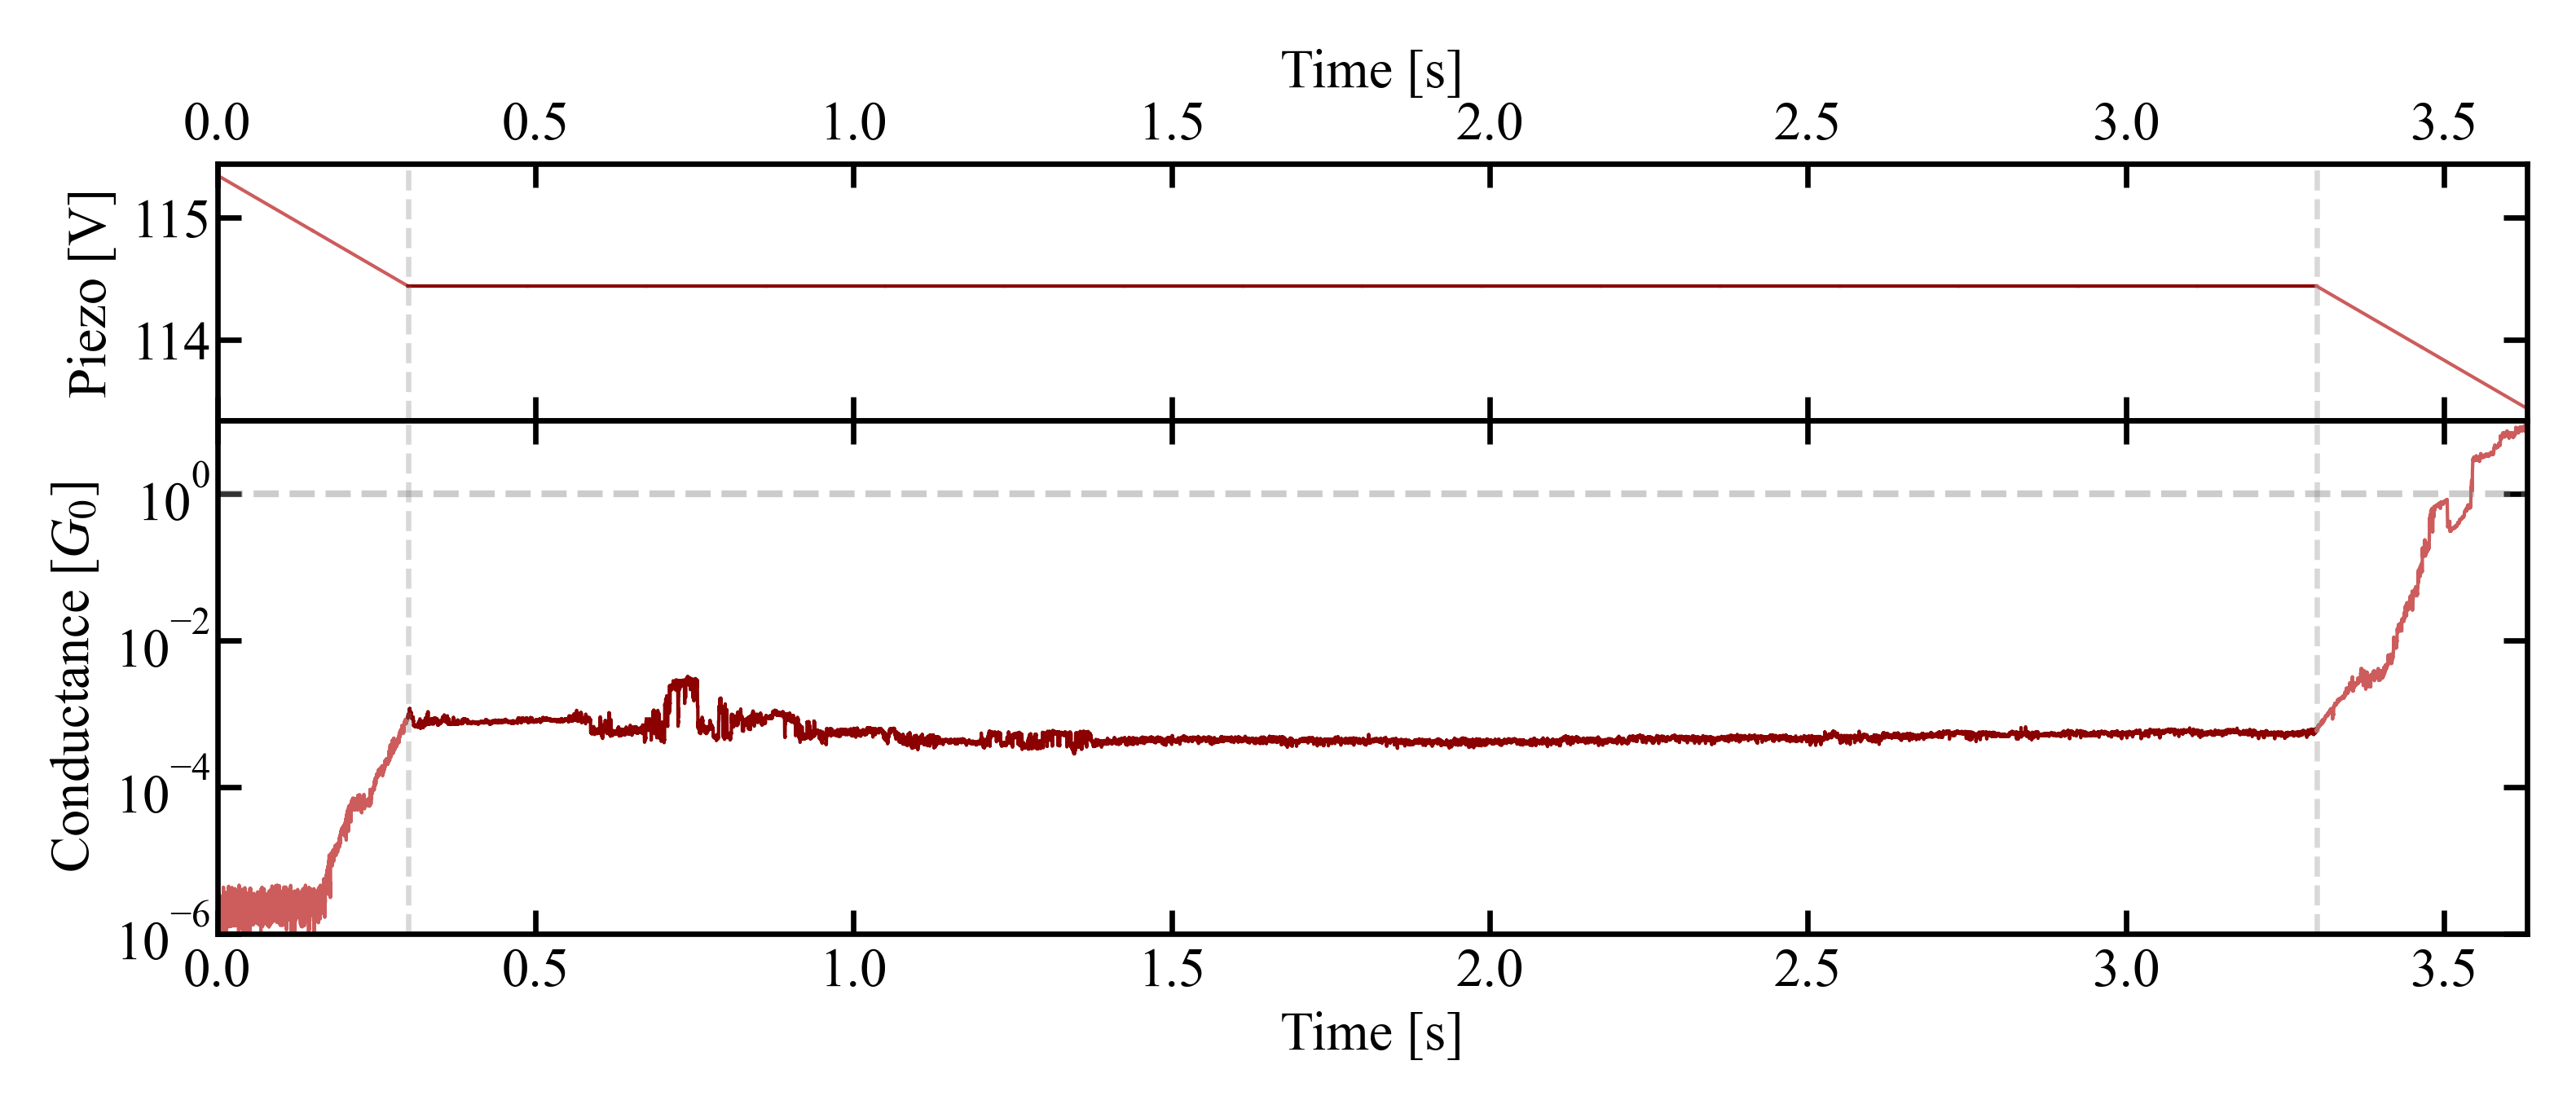

In [39]:
ax = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='push',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax[1].axhline(1, ls='--', c='grey', alpha=0.4, lw = 1)

In [40]:
which_trace = 8409
print(which_trace)

hold_trace = HoldTrace(which_trace, load_from=home_folder, bias_offset=0.00126,
                       r_serial_ohm=100_000, min_step_len=20_000, min_height=1)
trace_pair = TracePair(f'trace_{which_trace}', load_from=home_folder)
hold_trace.analyse_hold_trace(num_of_fft=1)

8409


(<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='G $[G_{0}]$'>,
 <AxesSubplot:xlabel='Time [s]', ylabel='G $[G_{0}]$'>)

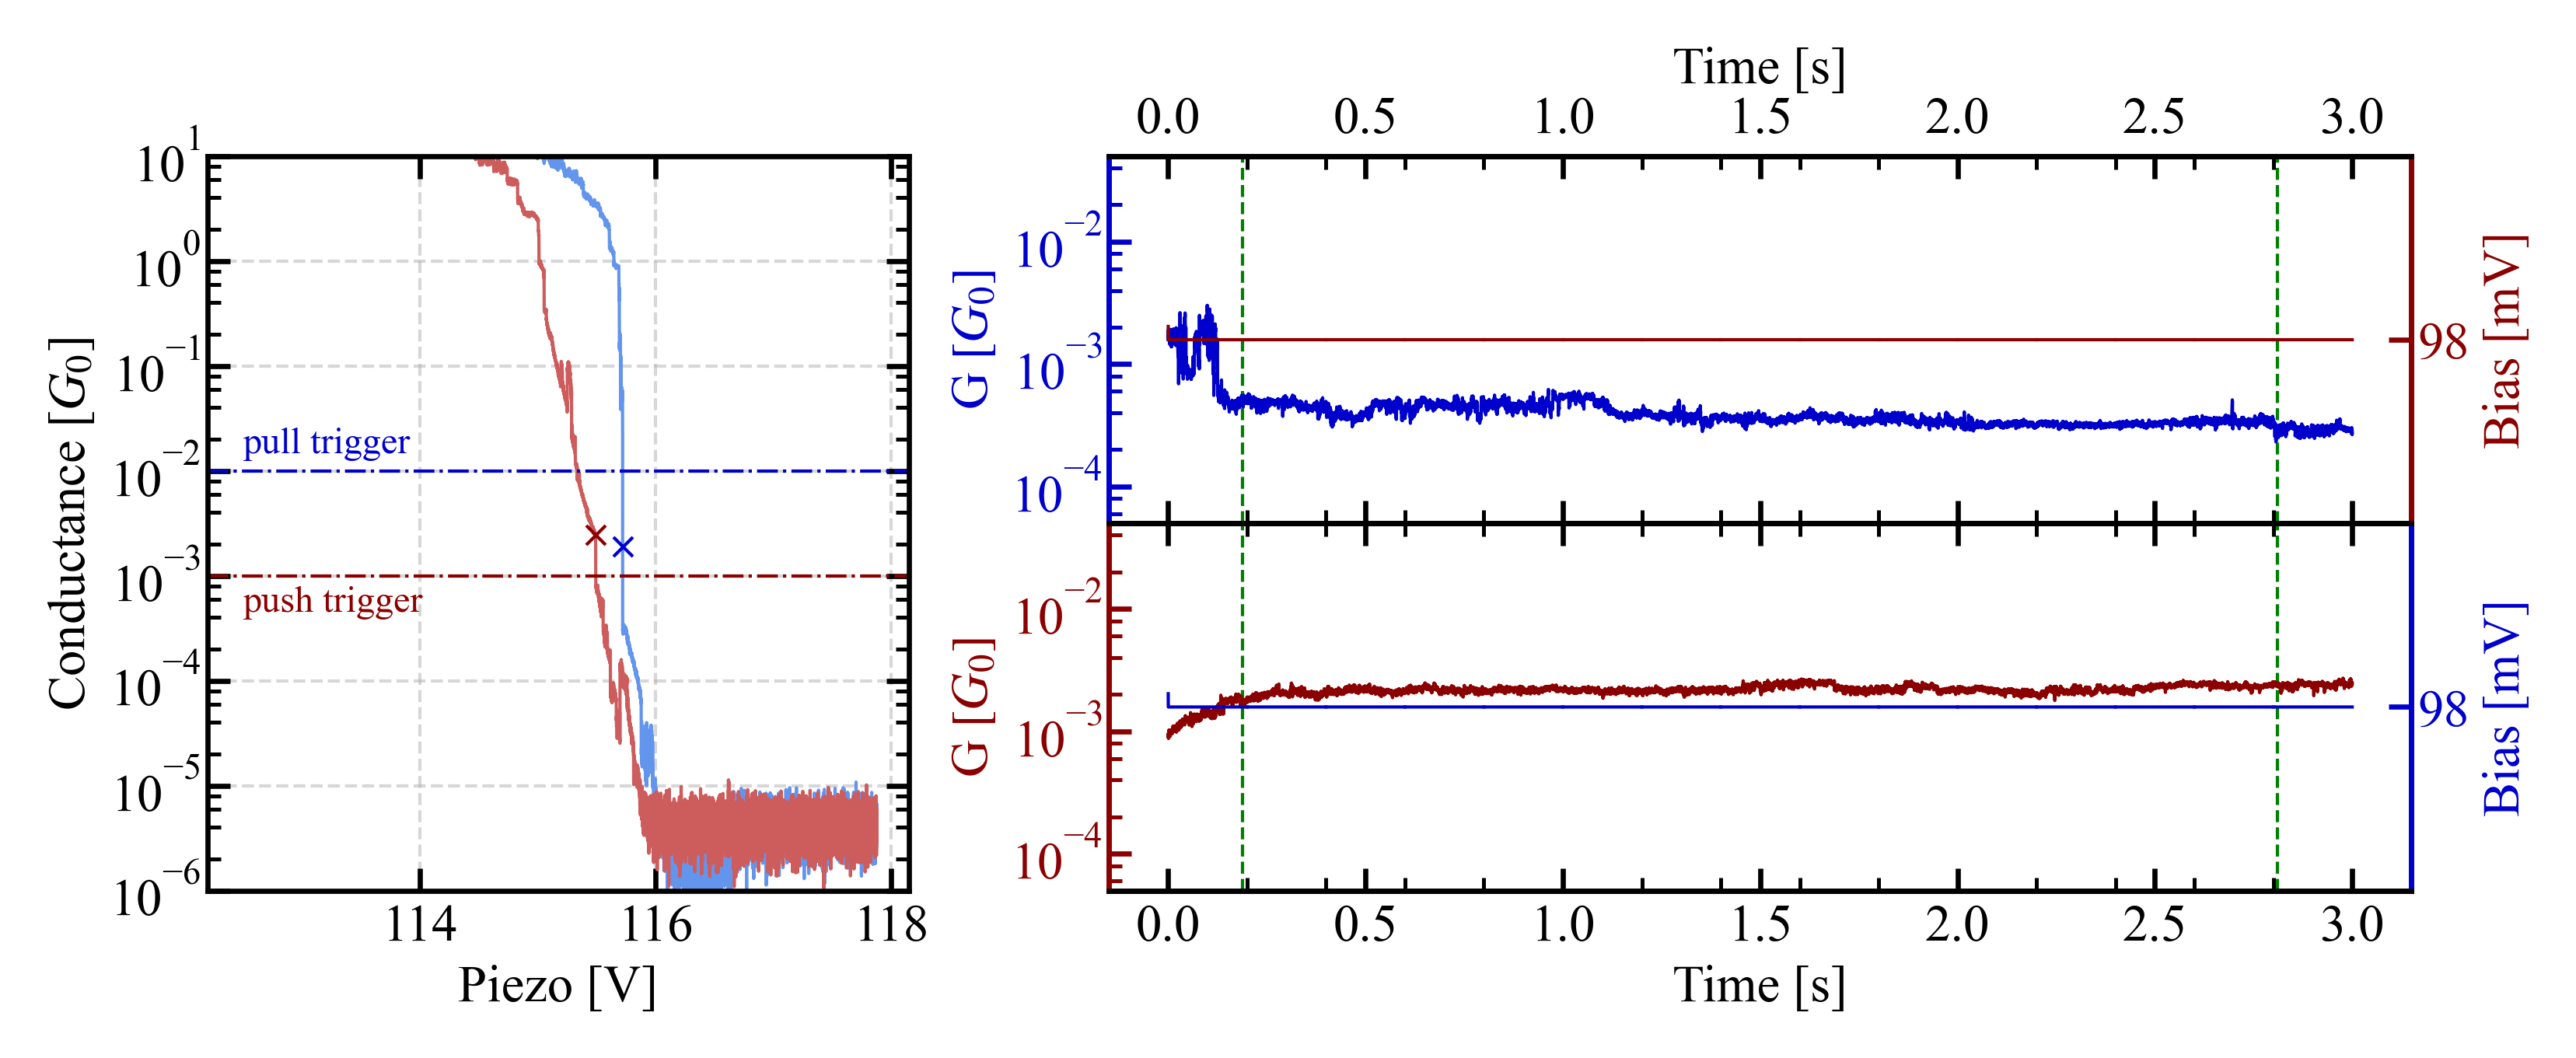

In [41]:
plots.plot_measurement_scheme(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder,
                              main_colors=('cornflowerblue', 'indianred'),
                              accent_colors=('mediumblue', 'darkred'),
                              save_fig=False,
                              xlim=None, smoothing=10)

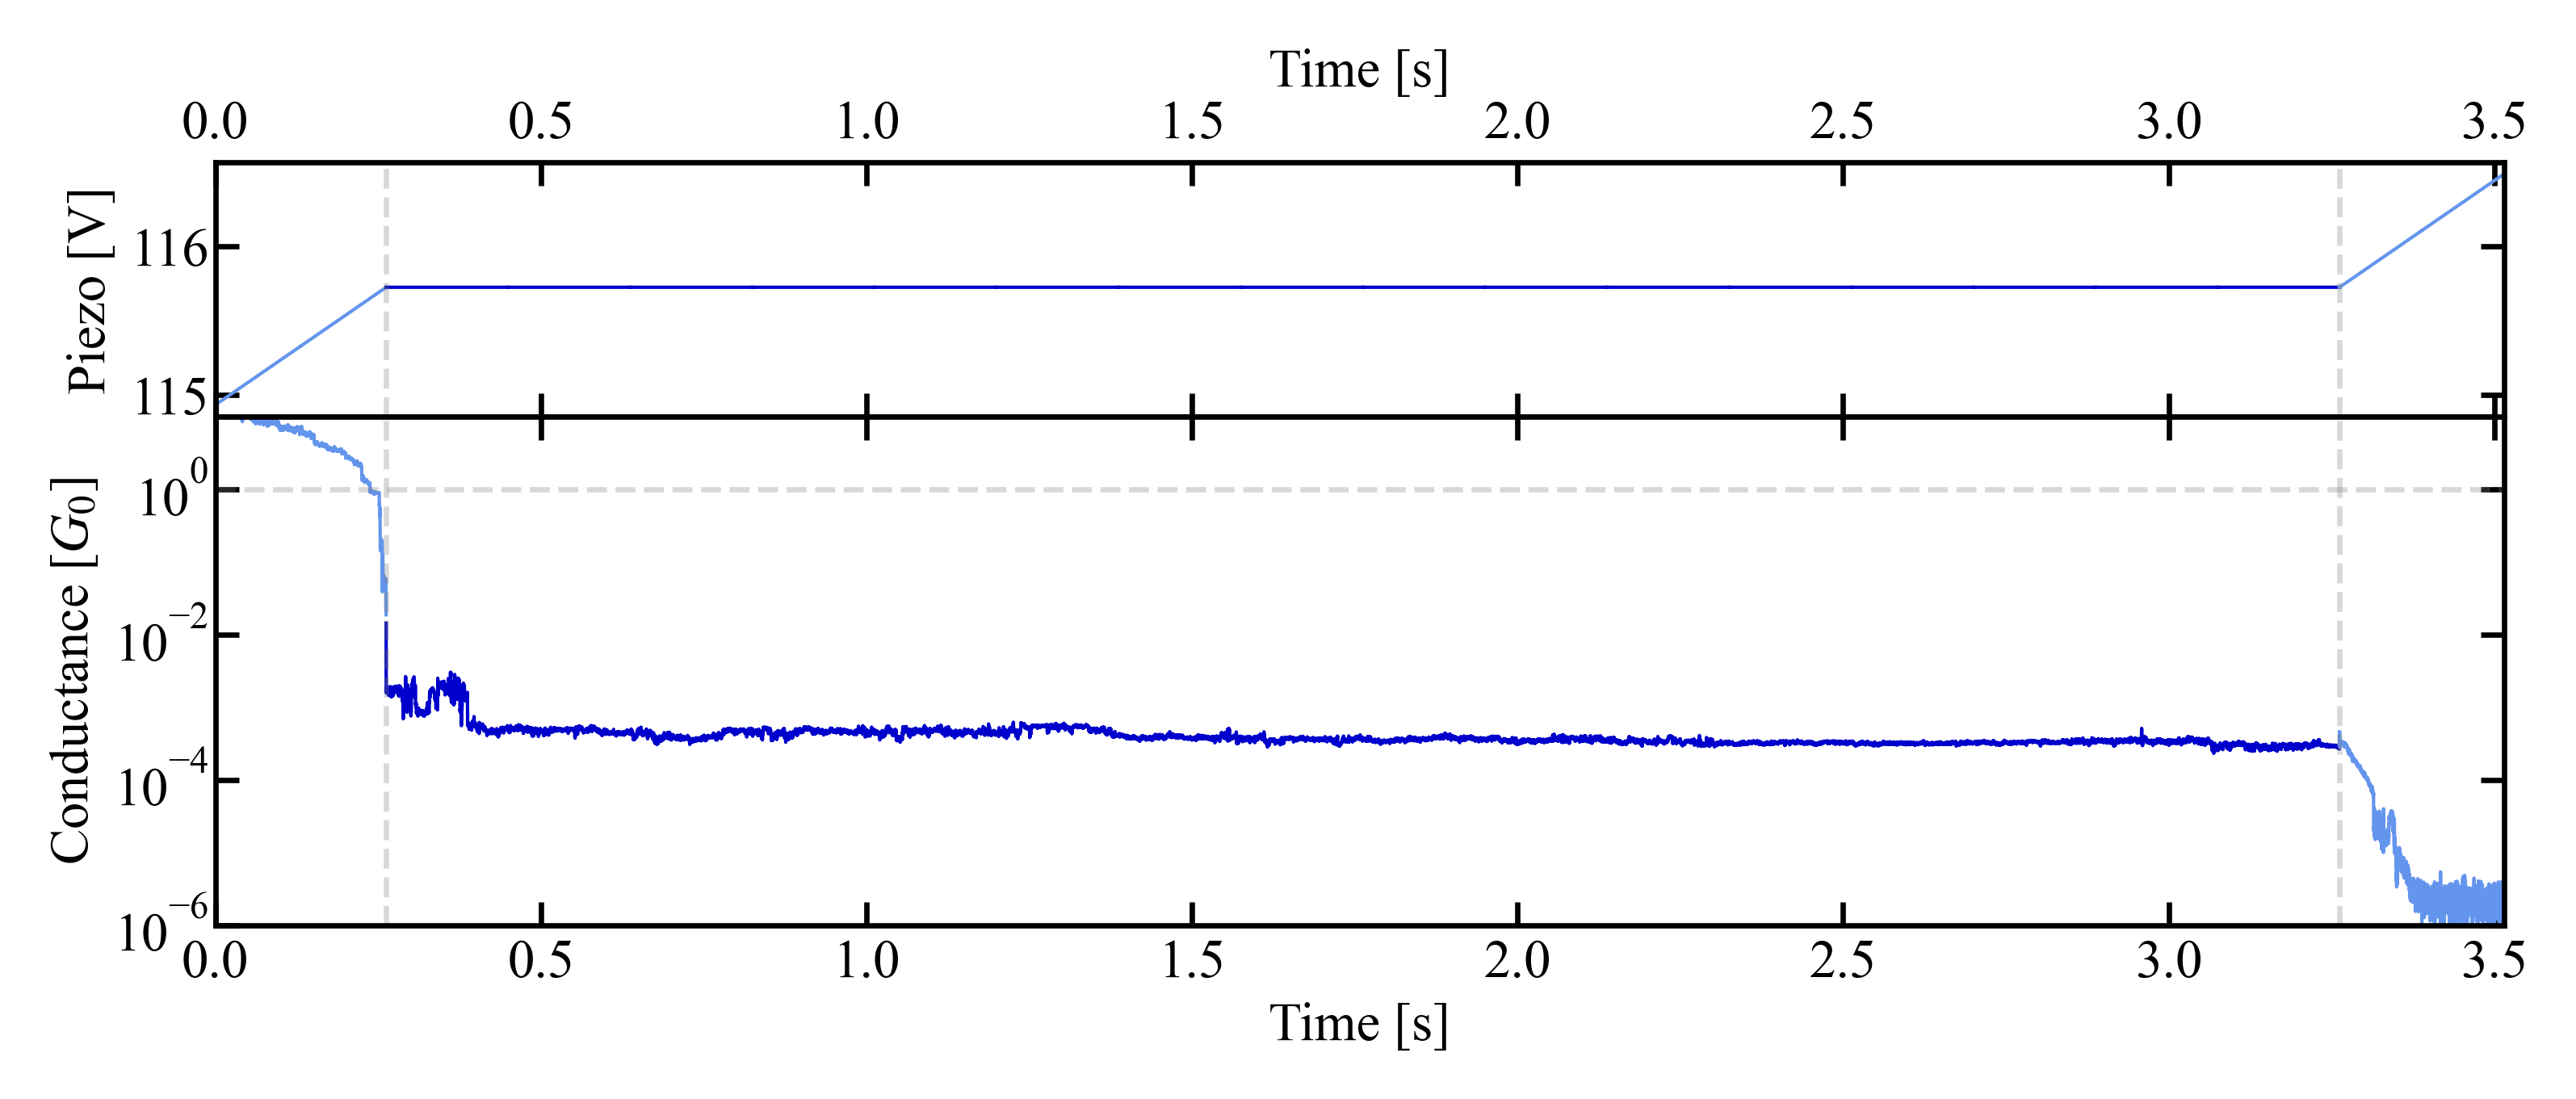

In [43]:
ax = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='pull',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax[1].axhline(1, ls='--', c='grey', alpha=0.3, lw = 0.8)
# ax.axvline((trace_pair.hold_index_pull + relax_ends_at)/50_000, ls='--', c='grey', alpha=0.4, lw = 1)

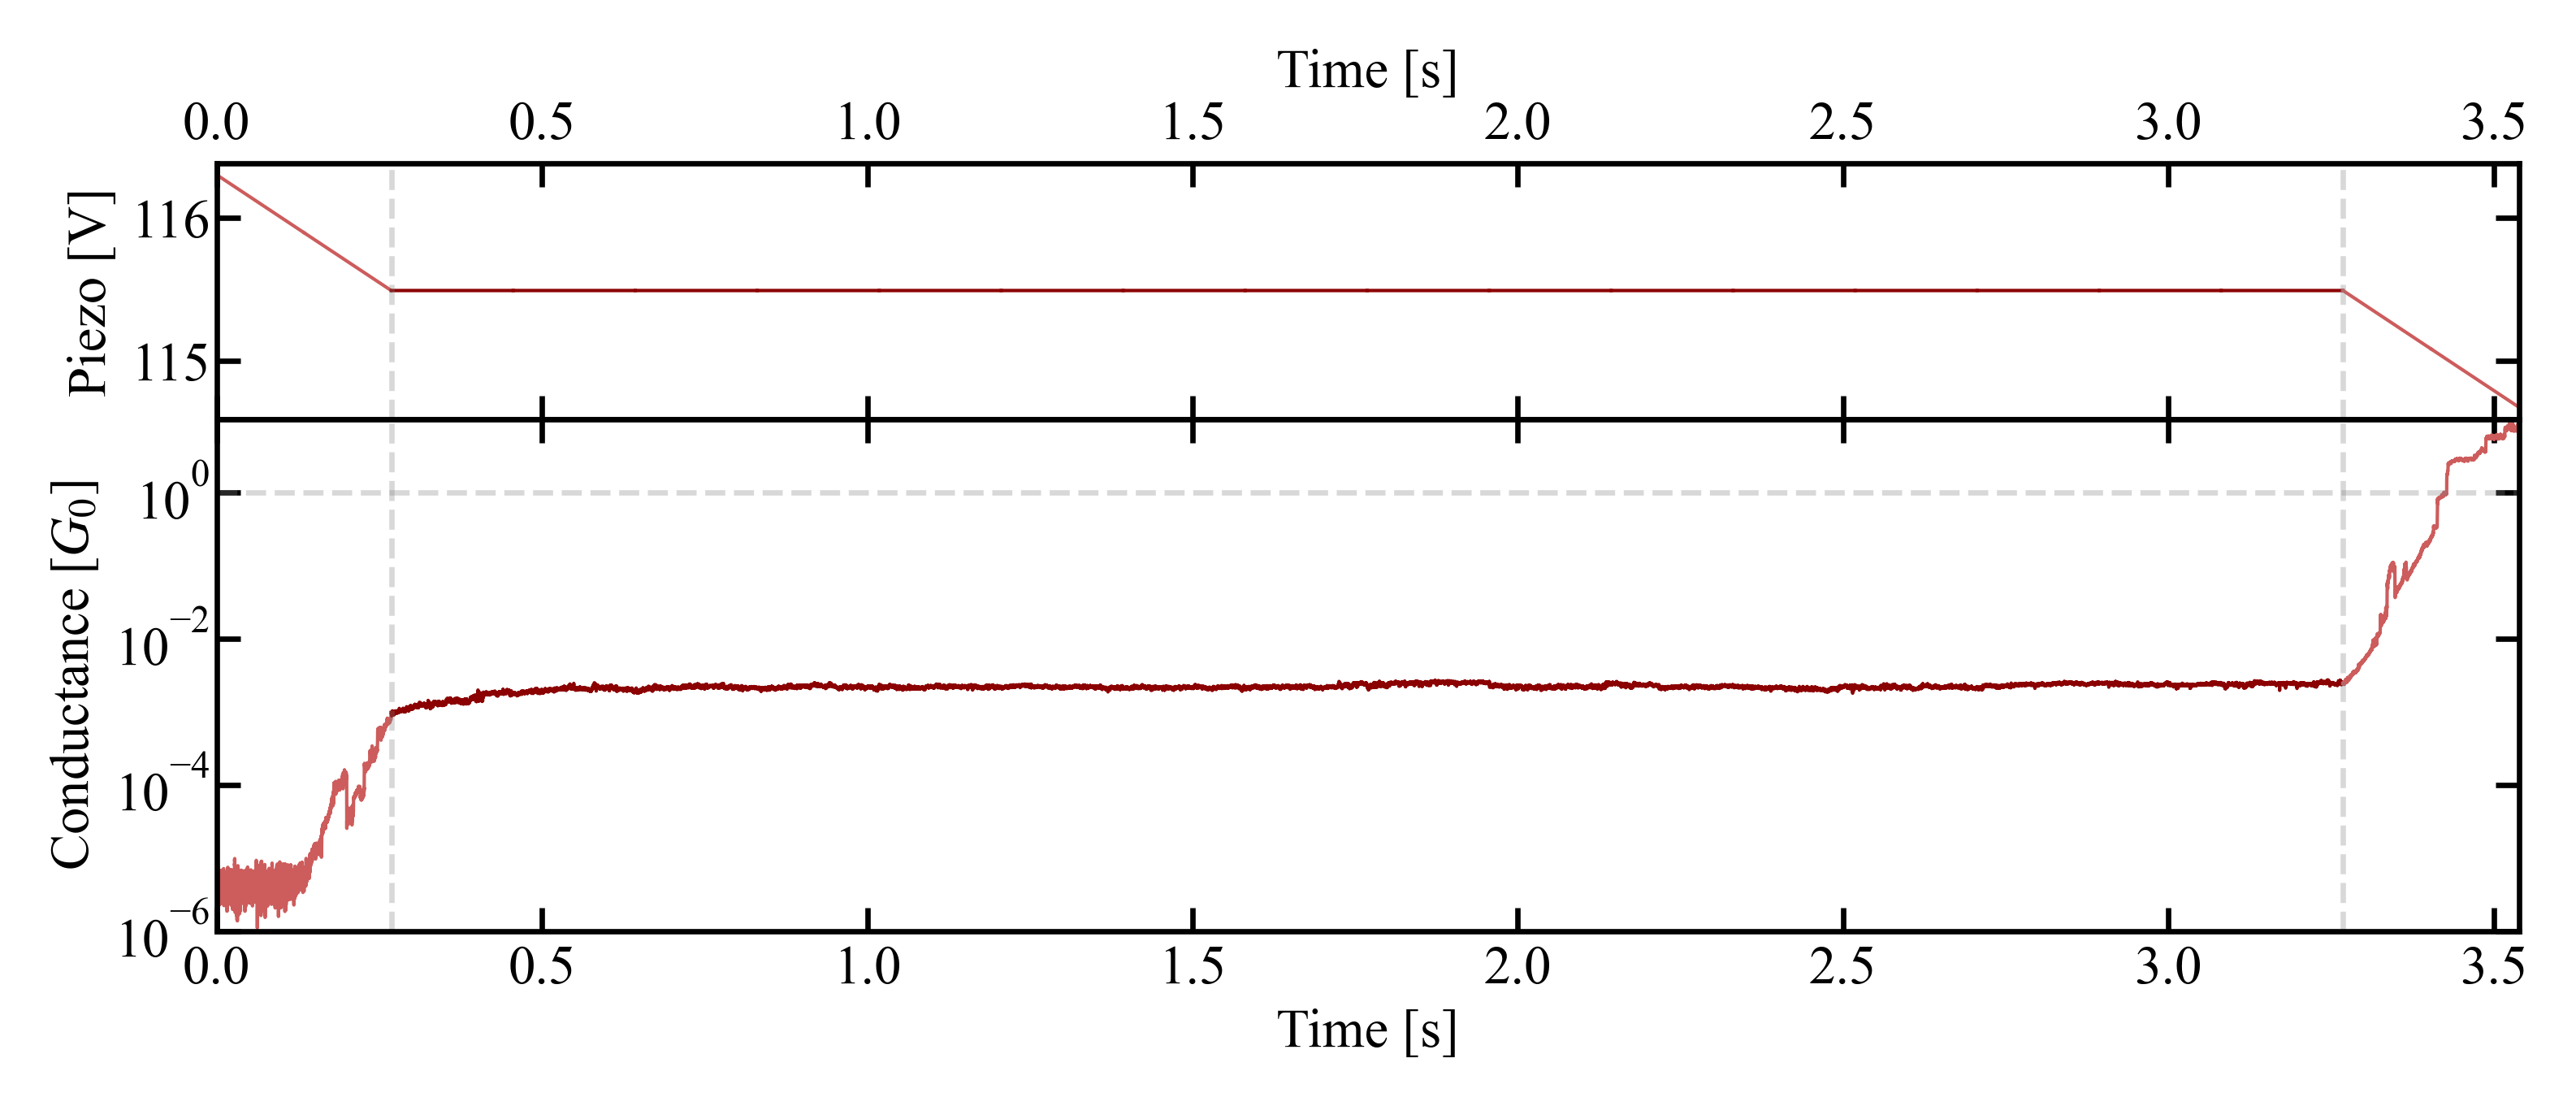

In [44]:
ax = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='push',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax[1].axhline(1, ls='--', c='grey', alpha=0.3, lw = 0.8)

In [45]:
relax_amount = hold_trace.hold_conductance_pull[0]-np.mean(hold_trace.hold_conductance_pull[:-int(len(hold_trace.hold_conductance_pull)/2)])
print(relax_amount)
print(hold_trace.hold_conductance_pull[0]/np.mean(hold_trace.hold_conductance_pull[:-int(len(hold_trace.hold_conductance_pull)/2)]))


0.001103302653337434
3.088775652417656


In [46]:
relax_amount = hold_trace.hold_conductance_push[0]-np.mean(hold_trace.hold_conductance_push[:-int(len(hold_trace.hold_conductance_push)/2)])
print(relax_amount)
print(np.mean(hold_trace.hold_conductance_push[:-int(len(hold_trace.hold_conductance_push)/2)])/hold_trace.hold_conductance_push[0])

-0.001080213638385832
2.1103887783429554


#### Collect traces that did not break

In [47]:
count_pull = 0
count_push = 0
did_not_break_pull = []
did_not_break_push = []

for i in tqdm(np.arange(8000, 23001)):
    try:
        hold_trace = HoldTrace(i, load_from=home_folder, bias_offset=0.00243,
                               r_serial_ohm=99_900, min_step_len=20_000, min_height=1)
    except KeyError:
        continue
    trace_pair = TracePair(f'trace_{i}', load_from=home_folder)
    hold_trace.analyse_hold_trace(num_of_fft=1)  
    
    if does_not_break(hold_trace.hold_conductance_pull[:hold_trace.bias_steps_ranges_pull[0, 1]]):
        count_pull+=1
        did_not_break_pull.append(i)
    if does_not_break(hold_trace.hold_conductance_push[:hold_trace.bias_steps_ranges_push[0, 1]]):
        count_push+=1
        did_not_break_push.append(i)

  0%|          | 0/15001 [00:00<?, ?it/s]

In [48]:
did_not_break_pull = np.array(did_not_break_pull)
did_not_break_push = np.array(did_not_break_push)

In [49]:
print(len(did_not_break_pull)/15001)
print(len(did_not_break_push)/15001)

0.37044197053529765
0.9650023331777882


In [50]:
print(len(np.intersect1d(did_not_break_pull, did_not_break_push))/15001)

0.3557762815812279


In [51]:
in_both = np.intersect1d(did_not_break_pull, did_not_break_push)

In [52]:
relax_amount_pull = []
relax_amount_push = []
relax_ratio_pull = []
relax_ratio_push = []

for i in tqdm(np.intersect1d(did_not_break_pull, did_not_break_push)):
    
    hold_trace = HoldTrace(i, load_from=home_folder, bias_offset=0.00243,
                           r_serial_ohm=99_900, min_step_len=20_000, min_height=1)
    trace_pair = TracePair(f'trace_{i}', load_from=home_folder)
    
    relax_amount = np.mean(hold_trace.hold_conductance_pull[0:50])-np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):])
    relax_amount_pull.append(relax_amount)
    relax_ratio_pull.append(np.mean(hold_trace.hold_conductance_pull[0:50])/np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):]))
    
    relax_amount = np.mean(hold_trace.hold_conductance_push[0:50])-np.mean(hold_trace.hold_conductance_push[-int(len(hold_trace.hold_conductance_push)/4):])
    relax_amount_push.append(relax_amount)
    relax_ratio_push.append(np.mean(hold_trace.hold_conductance_push[-int(len(hold_trace.hold_conductance_push)/4):])/np.mean(hold_trace.hold_conductance_push[0:50]))

  0%|          | 0/5337 [00:00<?, ?it/s]

In [53]:
relax_ratio_pull = np.array(relax_ratio_pull)
relax_ratio_push = np.array(relax_ratio_push)

In [54]:
relax_amount_pull = np.array(relax_amount_pull)
relax_amount_push = np.array(relax_amount_push)

In [55]:
max(relax_ratio_pull)

10646.475019419033

In [56]:
max(relax_ratio_push)

83.89613294656858

In [57]:
bins_pull, single_hist_pull = utils.calc_hist_1d_single(data=relax_ratio_pull,
                                                        xrange=(0, 100),
                                                        xbins_num=300,
                                                        log_scale=False)

bins_push, single_hist_push = utils.calc_hist_1d_single(data=relax_ratio_push,
                                                        xrange=(0, 100),
                                                        xbins_num=300,
                                                        log_scale=False)

In [58]:
print(min(relax_ratio_pull))

0.023892144034281627


130
653


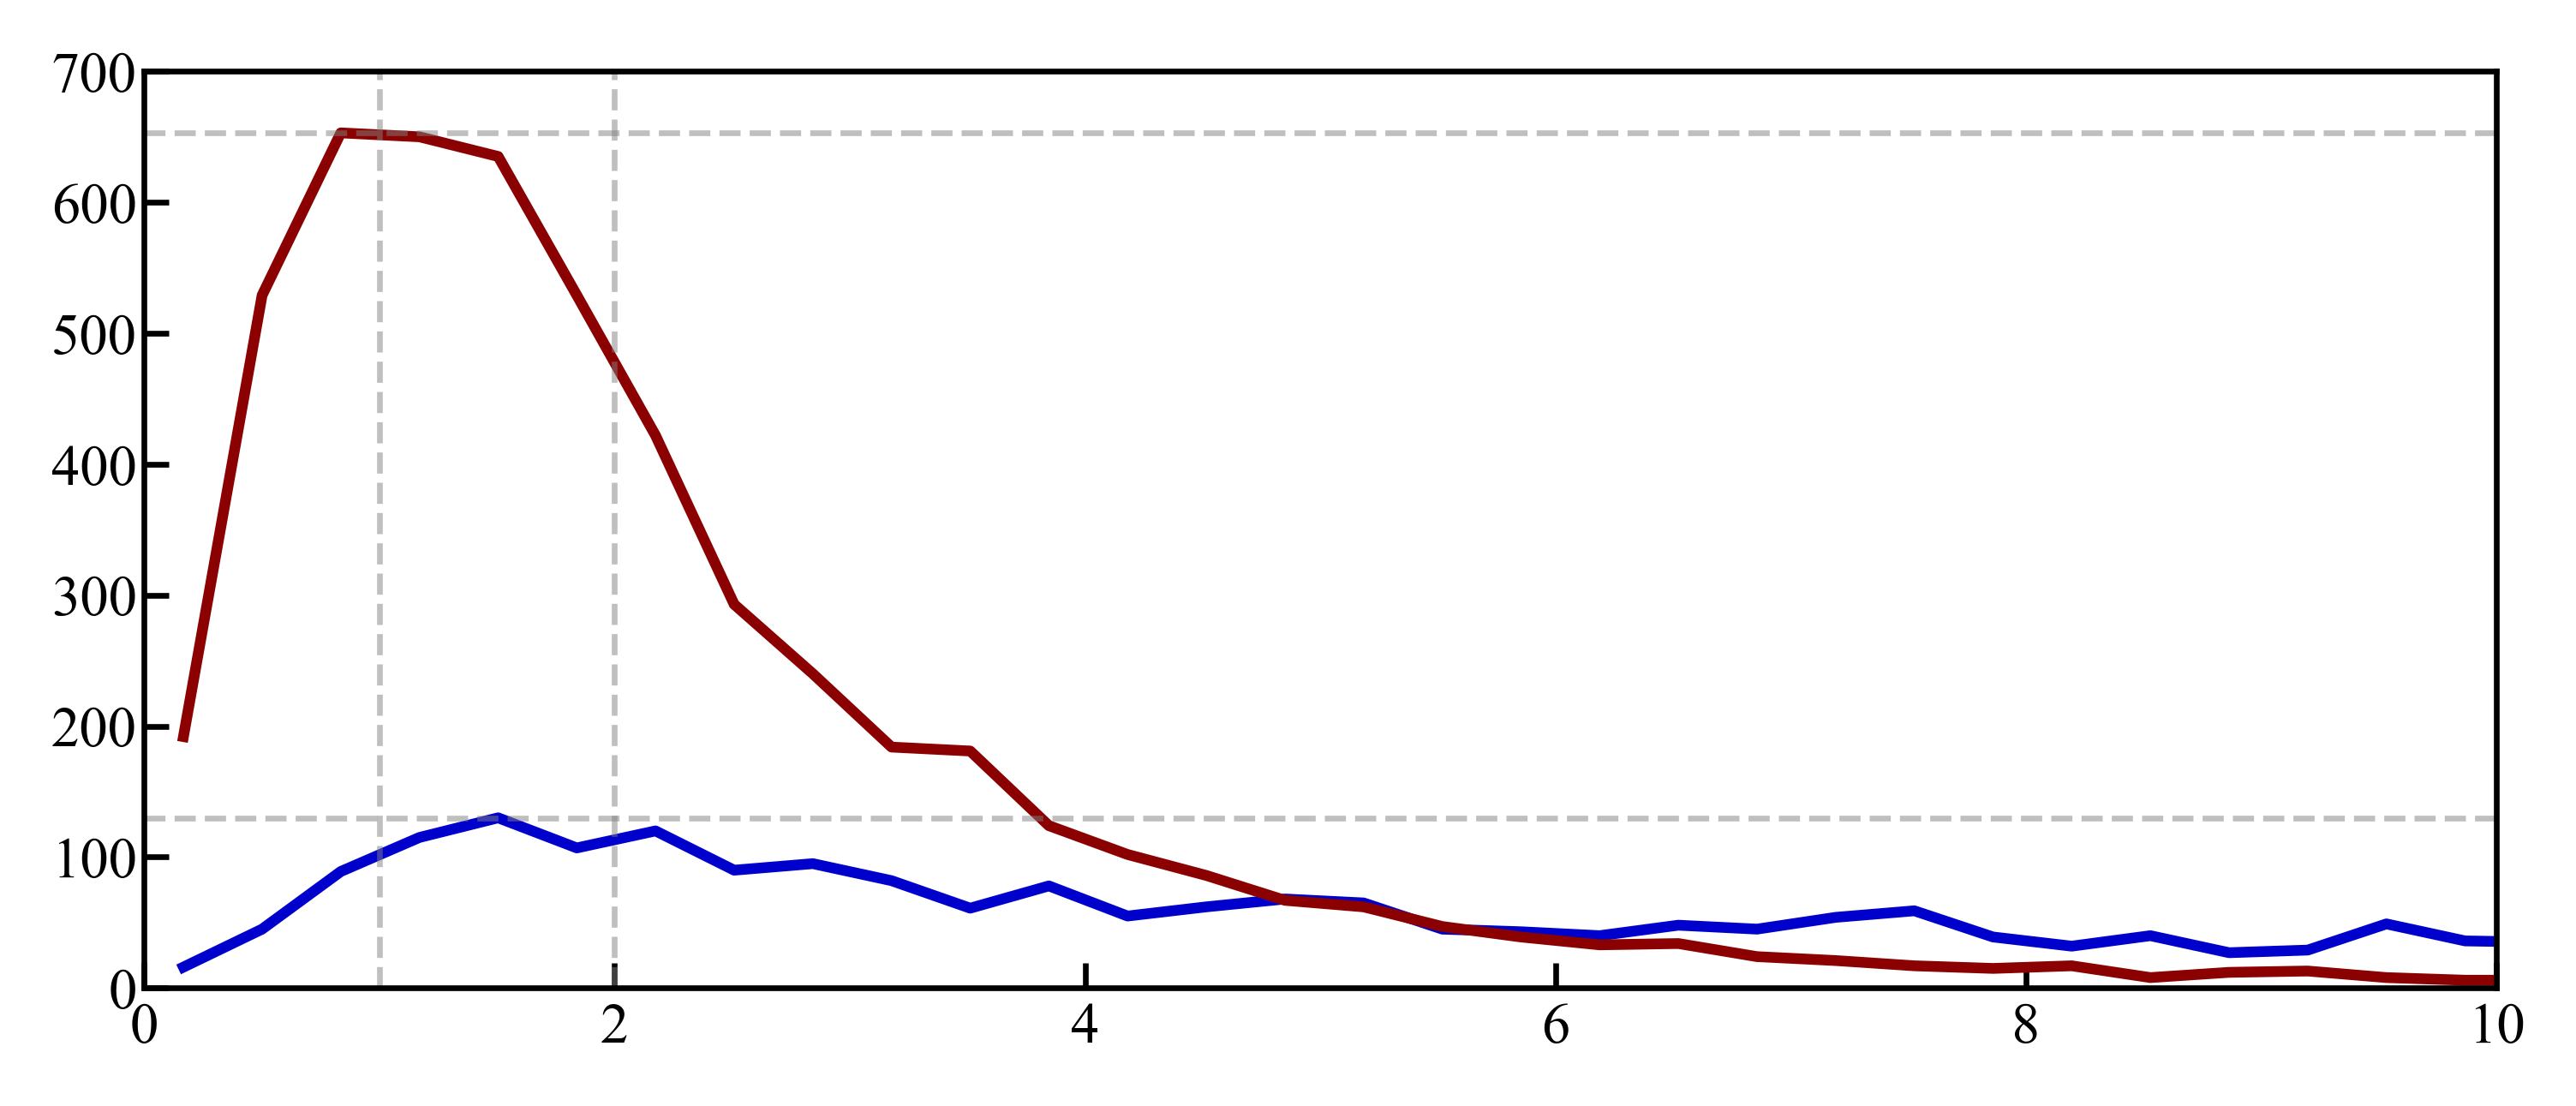

In [59]:
fig, ax = plt.subplots(1, dpi=600, figsize=utils.cm2inch(15, 6))
ax.plot(bins_pull, single_hist_pull, c='mediumblue')
ax.plot(bins_push, single_hist_push, c='darkred')
ax.axvline(2, ls='--', lw=0.8, c='grey', alpha=0.5)
ax.axvline(1, ls='--', lw=0.8, c='grey', alpha=0.5)
ax.set_ylim(0, 700)
ax.set_xlim(0, 10)
ax.axhline(max(single_hist_pull), ls='--', lw=0.8, c='grey', alpha=0.5)
ax.axhline(max(single_hist_push), ls='--', lw=0.8, c='grey', alpha=0.5)
# ax.set_xticks(np.arange(0, 105, 5))
print(max(single_hist_pull))
print(max(single_hist_push))

In [60]:
print('all traces:')
print(len(in_both))
print('relaxation greater than zero:')
print(len(in_both[relax_ratio_pull>0])/len(in_both))
print(len(in_both[relax_ratio_push>0])/len(in_both))

print('relaxation less than 2, greater than 0.5:')
print(len(in_both[np.bitwise_and(relax_ratio_pull<2, relax_ratio_pull>0.5)])/len(in_both))
print(len(in_both[np.bitwise_and(relax_ratio_push<2, relax_ratio_push>0.5)])/len(in_both))

print('relaxation greater than 2:')
print(len(in_both[relax_ratio_pull>2])/len(in_both))
print(len(in_both[relax_ratio_push>2])/len(in_both))

all traces:
5337
relaxation greater than zero:
1.0
1.0
relaxation less than 2, greater than 0.5:
0.08806445568671538
0.5156454937230653
relaxation greater than 2:
0.9059396664792955
0.40434701142964213


In [61]:
print(len(in_both[np.bitwise_and(relax_ratio_pull<10, relax_ratio_pull>2)]))

1357


In [62]:
which_trace = np.random.choice(in_both[np.bitwise_and(relax_ratio_pull<10, relax_ratio_pull>2)])
# which_trace=16245
print(which_trace)

hold_trace = HoldTrace(which_trace, load_from=home_folder, bias_offset=0.00126,
                       r_serial_ohm=100_000, min_step_len=20_000, min_height=1)
trace_pair = TracePair(f'trace_{which_trace}', load_from=home_folder)
hold_trace.analyse_hold_trace(num_of_fft=1)

8035


In [63]:
print('PULL')
print('relax_amount: ', np.mean(hold_trace.hold_conductance_pull[0:50])-np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):]), 'G0')
print('cond ratio: ', np.mean(hold_trace.hold_conductance_pull[0:50])/np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):]))
print('beginning: ', np.mean(hold_trace.hold_conductance_pull[0:50]), 'G0')
print('end: ', np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):]), 'G0')

PULL
relax_amount:  0.008751986789941053 G0
cond ratio:  5.814328613060122
beginning:  0.010569890695835431 G0
end:  0.001817903905894377 G0


In [64]:
print('PUSH')
print('relax_amount: ', np.mean(hold_trace.hold_conductance_push[-int(len(hold_trace.hold_conductance_push)/4):]) - np.mean(hold_trace.hold_conductance_push[0:50]), 'G0')
print('cond ratio: ', np.mean(hold_trace.hold_conductance_push[-int(len(hold_trace.hold_conductance_push)/4):])/np.mean(hold_trace.hold_conductance_push[0:50]))
print('beginning: ', np.mean(hold_trace.hold_conductance_push[0:50]), 'G0')
print('end: ', np.mean(hold_trace.hold_conductance_push[-int(len(hold_trace.hold_conductance_push)/4):]), 'G0')

PUSH
relax_amount:  -0.0007034045995017752 G0
cond ratio:  0.2616415364241749
beginning:  0.0009526600346601697 G0
end:  0.00024925543515839455 G0


In [65]:
np.mean(hold_trace.hold_conductance_pull[-int(len(hold_trace.hold_conductance_pull)/4):])

0.001817903905894377

In [66]:
hold_trace.hold_bias_pull[:10]

array([0.10124699, 0.10124699, 0.0988361 , 0.0988361 , 0.0988361 ,
       0.0988361 , 0.0988361 , 0.0988361 , 0.0988361 , 0.0988361 ],
      dtype=float32)

(1e-05, 0.05)

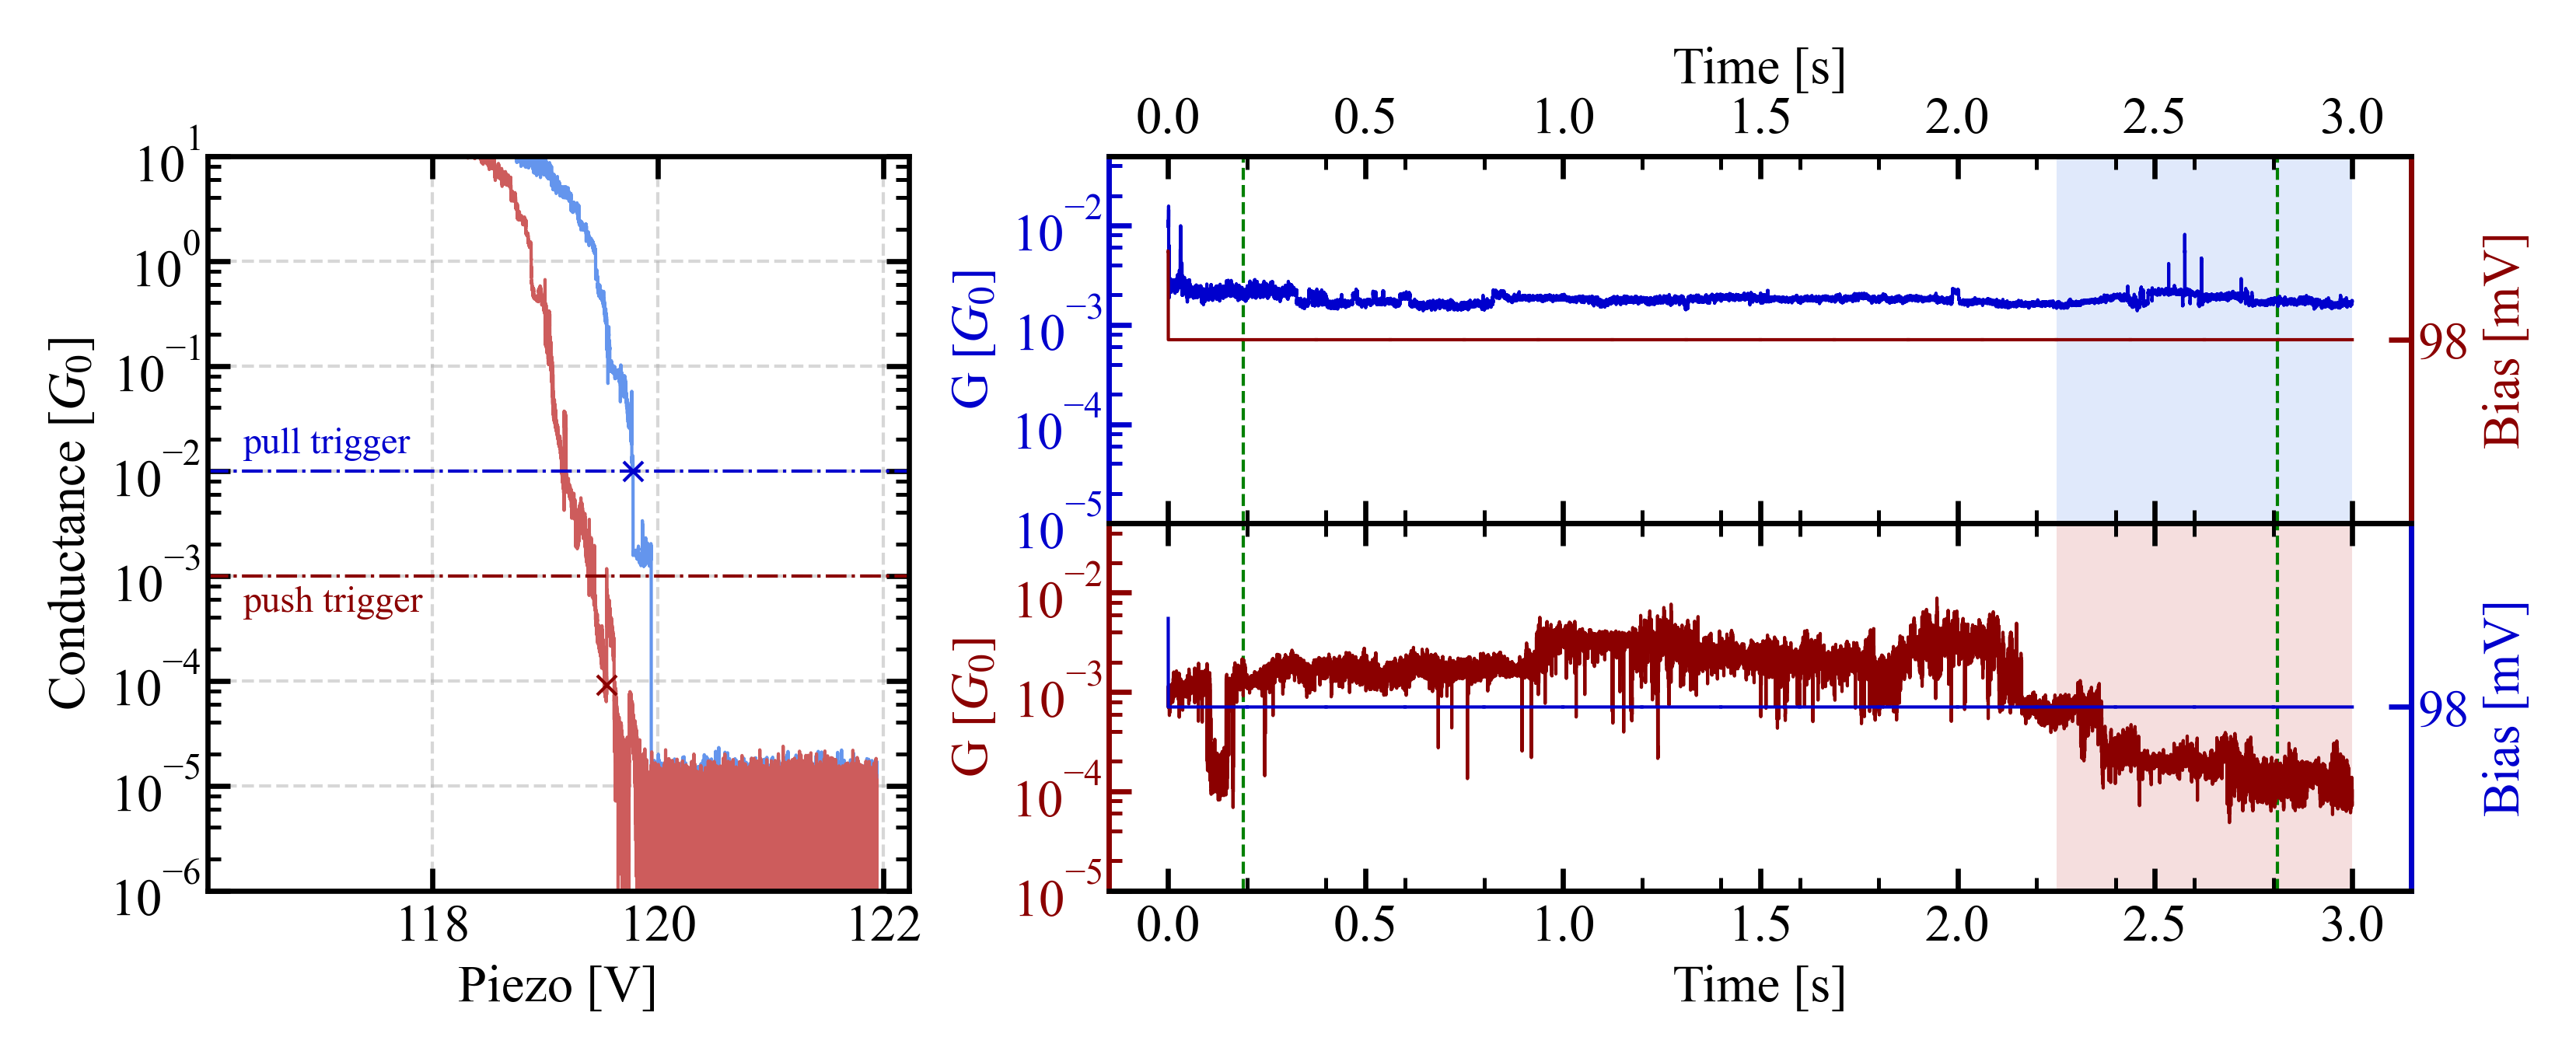

In [67]:
ax_trace, ax_pull, ax_push = plots.plot_measurement_scheme(trace_pair=trace_pair,
                                                           hold_trace=hold_trace,
                                                           home_folder=home_folder,
                                                           main_colors=('cornflowerblue', 'indianred'),
                                                           accent_colors=('mediumblue', 'darkred'),
                                                           save_fig=False,
                                                           xlim=None, smoothing=1)
# ax_pull.axvline(3*len(hold_trace.hold_conductance_pull)/4/50_000, ls='--', c='grey', alpha=0.3, lw = 0.8)
# ax_push.axvline(3*len(hold_trace.hold_conductance_push)/4/50_000, ls='--', c='grey', alpha=0.3, lw = 0.8)
ax_pull.axvspan(20/50_000, 50/50_000, alpha=0.2, color='cornflowerblue', ec=None)
ax_pull.axvspan(3*len(hold_trace.hold_conductance_pull)/4/50_000,
           len(hold_trace.hold_conductance_pull)/50_000, alpha=0.2, color='cornflowerblue', ec=None)
ax_push.axvspan(20/50_000, 50/50_000, alpha=0.2, color='indianred', ec=None)
ax_push.axvspan(3*len(hold_trace.hold_conductance_push)/4/50_000,
           len(hold_trace.hold_conductance_push)/50_000, alpha=0.2, color='indianred', ec=None)
ax_pull.set_ylim(1e-5)
ax_push.set_ylim(1e-5)
# ax_pull.set_xlim(-0.0005, 0.002)
# ax_push.set_xlim(-0.0005, 0.002)

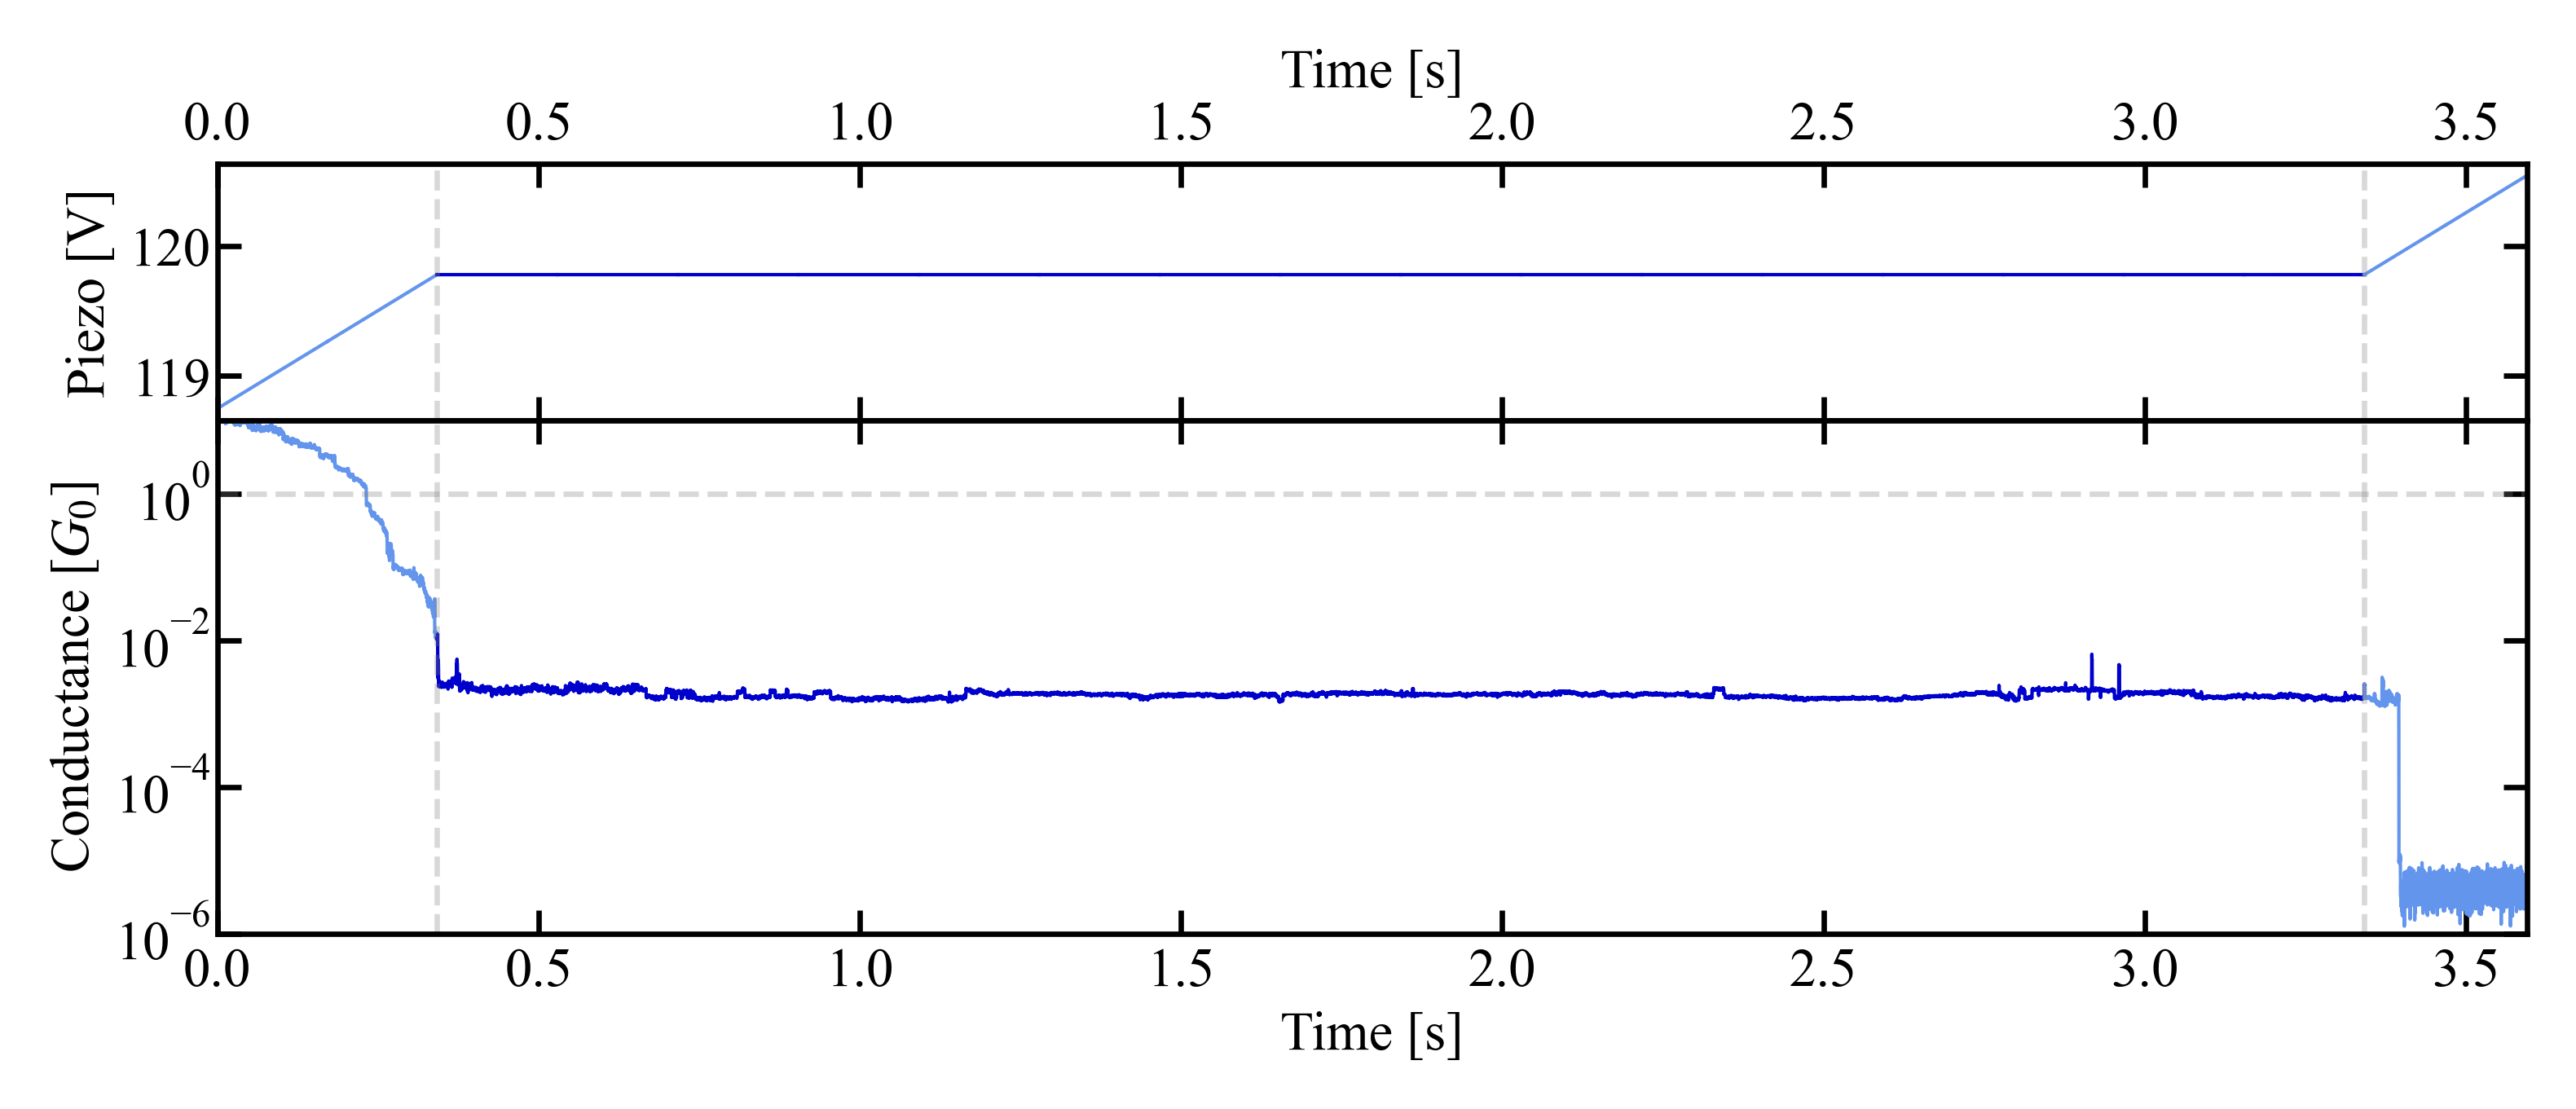

In [69]:
ax = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='pull',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax[1].axhline(1, ls='--', c='grey', alpha=0.3, lw = 0.8)
# ax.axvline((trace_pair.hold_index_pull + relax_ends_at)/50_000, ls='--', c='grey', alpha=0.4, lw = 1)

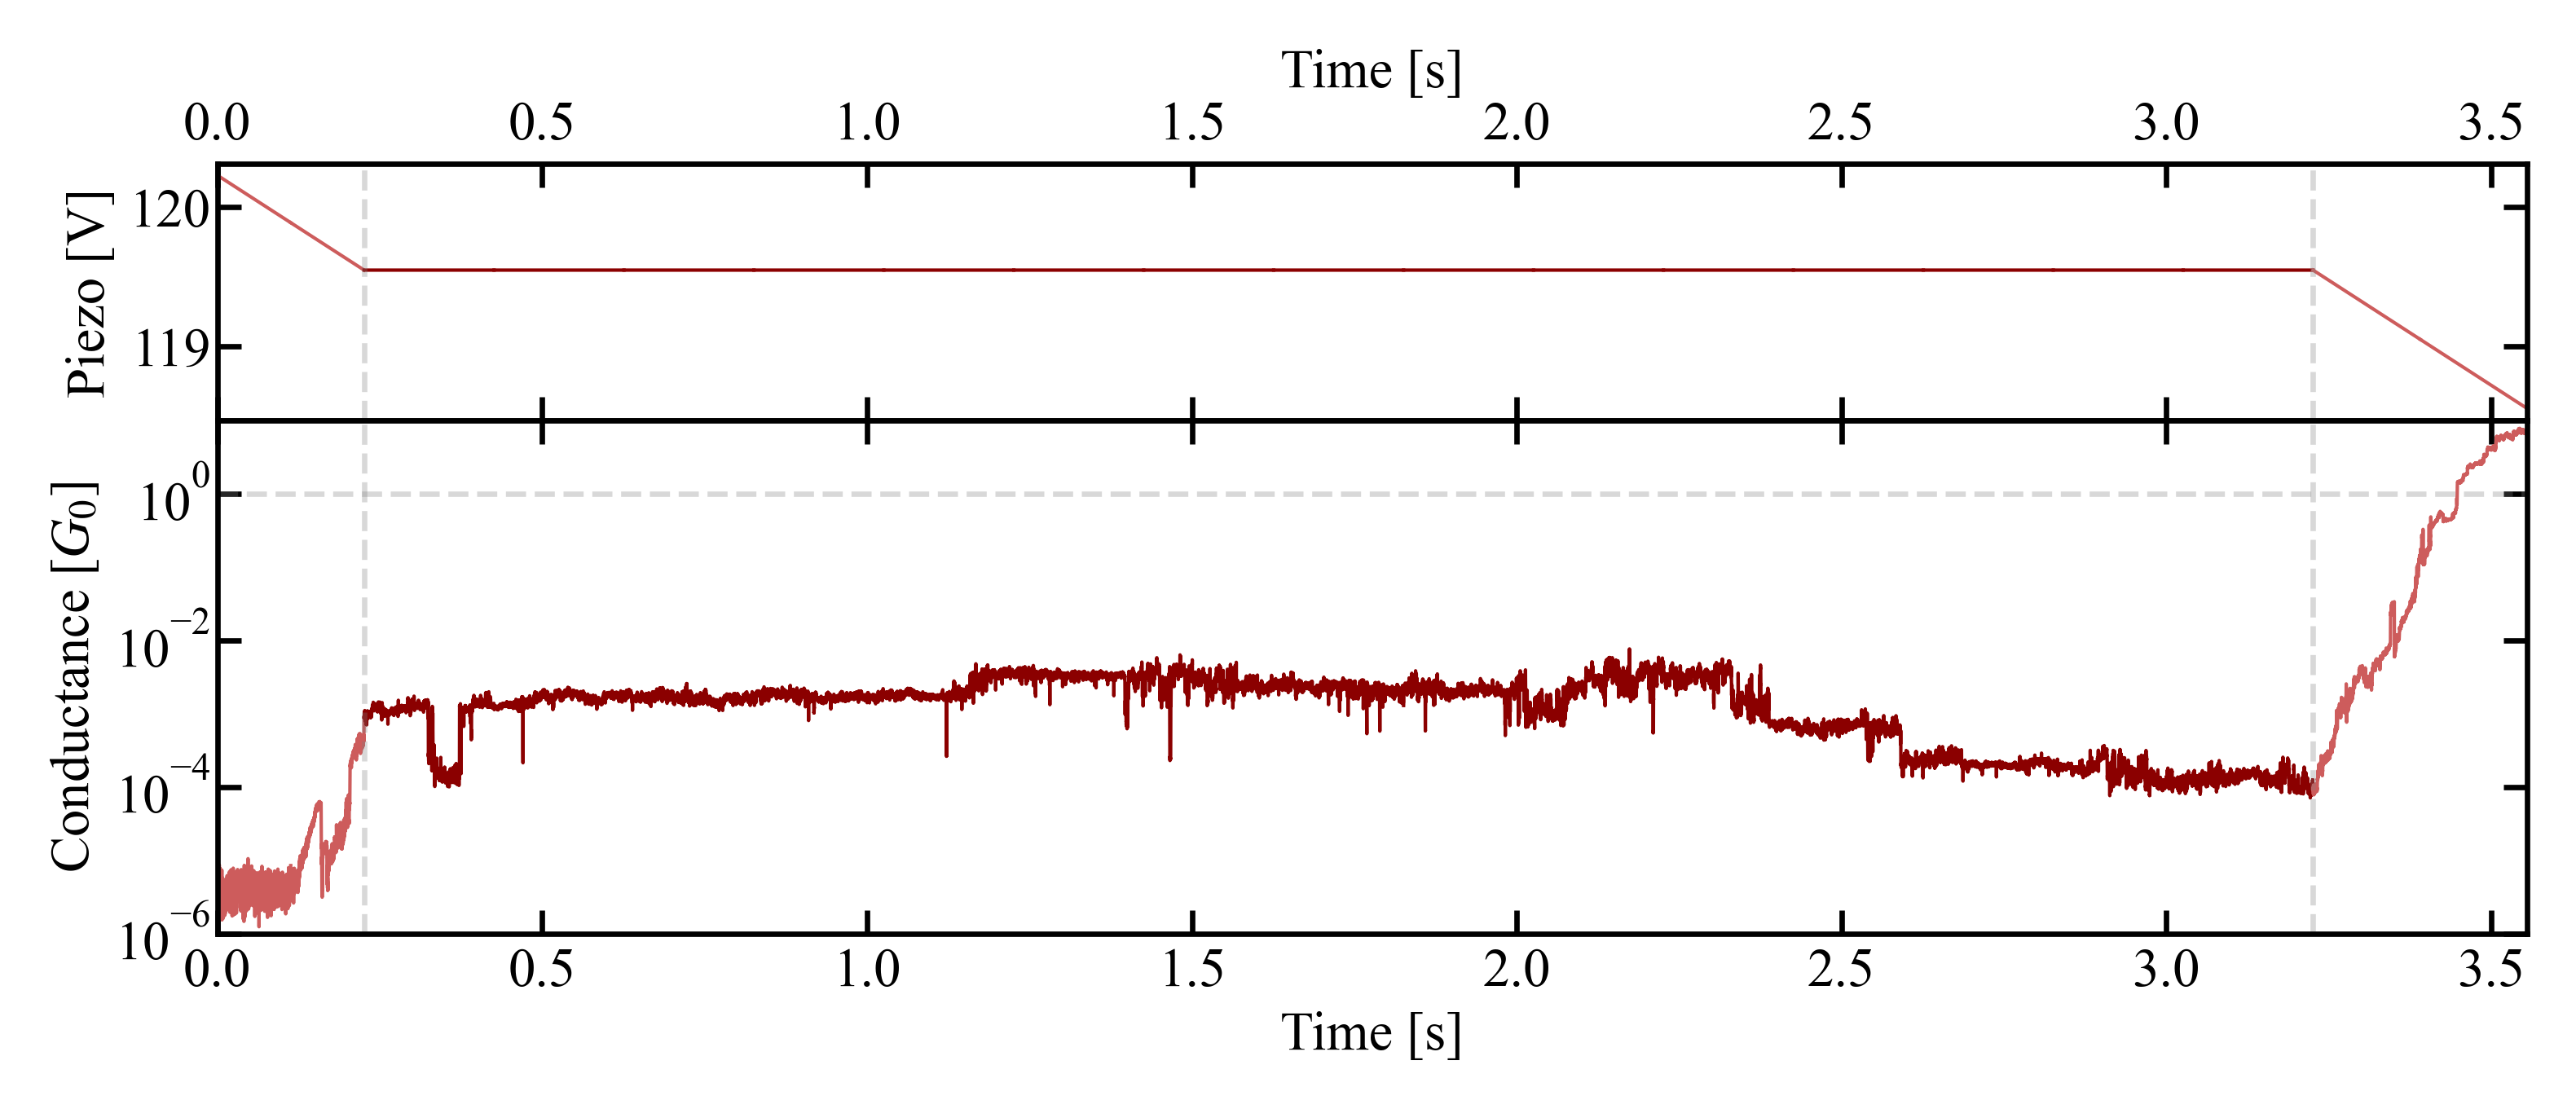

In [70]:
ax = plots.plot_measurement_scheme_combed(trace_pair=trace_pair, hold_trace=hold_trace, home_folder=home_folder, smoothing=10,
                                          direction='push',
                                          main_colors=('cornflowerblue', 'indianred'),
                                          accent_colors=('mediumblue', 'darkred'),
                                          add_vlines_for_hold=True,
                                          save_fig=False)
ax[1].axhline(1, ls='--', c='grey', alpha=0.3, lw = 0.8)